In [2]:
# load a coffea file
from coffea.util import load
import os
import awkward as ak
import numpy as np
import matplotlib.pyplot as plt
import mplhep as hep
import matplotlib
from scipy.stats import pearsonr
# from distance_correlation import distance_correlation
plt.style.use(hep.style.CMS)
import torch

matplotlib.rcParams["figure.dpi"] = 300

/work/mmalucch/micromamba/envs/ML_pytorch/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# REGION='control_region'
# REGION='signal_region'
REGION='baseline'
NUM_EVENTS=-1


In [4]:
# from https://gitlab.cern.ch/cms-analysis/mlg/mlg-23-003/abcdiscotec/-/blob/master/abcdiscotec/_utilities.py?ref_type=heads
def distance_correlation(
        var_1:torch.tensor,
        var_2:torch.tensor,
        normedweight:torch.tensor,
        power=1,
        )->torch.tensor:
    """
    Compute the distance correlation function
    between two variables.

    Args:
        var_1 (torch.tensor): The first variable.
        var_2 (torch.tensor): The second variable.
        normedweight (torch.tensor): The weight matrix.
        power (int): The power of the distance correlation.

    Returns:
        torch.tensor: The distance correlation between the two variables.
    """
    
    # Normalize the weights
    normedweight = normedweight/torch.sum(normedweight)*len(var_1)
    
    xx = var_1.view(-1, 1).repeat(1, len(var_1)).view(len(var_1),len(var_1))
    yy = var_1.repeat(len(var_1),1).view(len(var_1),len(var_1))
    amat = (xx-yy).abs()

    xx = var_2.view(-1, 1).repeat(1, len(var_2)).view(len(var_2),len(var_2))
    yy = var_2.repeat(len(var_2),1).view(len(var_2),len(var_2))
    bmat = (xx-yy).abs()

    amatavg = torch.mean(amat*normedweight,dim=1)
    Amat=amat-amatavg.repeat(len(var_1),1).view(len(var_1),len(var_1))\
        -amatavg.view(-1, 1).repeat(1, len(var_1)).view(len(var_1),len(var_1))\
        +torch.mean(amatavg*normedweight)

    bmatavg = torch.mean(bmat*normedweight,dim=1)
    Bmat=bmat-bmatavg.repeat(len(var_2),1).view(len(var_2),len(var_2))\
        -bmatavg.view(-1, 1).repeat(1, len(var_2)).view(len(var_2),len(var_2))\
        +torch.mean(bmatavg*normedweight)

    ABavg = torch.mean(Amat*Bmat*normedweight,dim=1)
    AAavg = torch.mean(Amat*Amat*normedweight,dim=1)
    BBavg = torch.mean(Bmat*Bmat*normedweight,dim=1)

    if(power==1):
        dCorr=(torch.mean(ABavg*normedweight))/torch.sqrt((torch.mean(AAavg*normedweight)*torch.mean(BBavg*normedweight)))
    elif(power==2):
        dCorr=(torch.mean(ABavg*normedweight))**2/(torch.mean(AAavg*normedweight)*torch.mean(BBavg*normedweight))
    else:
        dCorr=((torch.mean(ABavg*normedweight))/torch.sqrt((torch.mean(AAavg*normedweight)*torch.mean(BBavg*normedweight))))**power
    
    return dCorr


In [5]:

def get_cols_from_file(input, region=REGION):
    o = load(f"{input}")
    sample=list(o["columns"].keys())[0]
    dataset=list(o["columns"][sample].keys())[0]
    categories = list(o["columns"][sample][dataset].keys())
    print(f"sample: {sample}, dataset: {dataset} categories: {categories}")
    col=o["columns"][sample][dataset][region]

    for k in col.keys():
        # print(k)
        col[k]=col[k].value
        
    return col

In [6]:
def correlation_plot(var1, var2, title, bins=(np.linspace(0, 1, 100), np.linspace(0, 8, 100))):
    var1 = ak.to_numpy(ak.flatten(var1, axis=None))
    var2 = ak.to_numpy(ak.flatten(var2, axis=None))
    # compute the correlation between the var1 of the 3rd jet and the var2
    plt.figure(figsize=(12, 12))
    # put the log in the color scale
    plt.hist2d(
        var1,
        var2,
        bins=bins,
        cmap="viridis",
        cmin=1,
        norm=matplotlib.colors.LogNorm(),
        density=False,
        weights=np.ones_like(var2),
    )
    plt.colorbar(label="Counts")

    # compute the correlation coefficient
    corr, _ = pearsonr(var1, var2)

    var1 = torch.tensor(var1)
    var2 = torch.tensor(var2)
    normedweight = torch.ones_like(var1)  # Assuming uniform weights for simplicity
    # disco = distance_correlation(var1, var2, normedweight, power=1)
    disco = 0
    print(f"Pearson correlation coefficient (spanet ): {corr:.6f}")

    plt.title(
        f"{title} \nPearson correlation coefficient: {corr:.6f} \nDistance correlation: {disco:.6f}"
    )

    plt.show()

    # plot the scatter plot
    # plt.scatter(var1, var2, s=1, alpha=0.5, color='red')
    # plt.title(f"{title} \nPearson correlation coefficient: {corr:.2f}")
    # plt.show()

In [7]:
def get_plot_cols(col):
    btag=col["JetGood_btagPNetB"]
    btag_unflattened=ak.unflatten(btag, col["JetGood_N"])[:NUM_EVENTS]
    pd=col["events_Arctanh_Delta_pairing_probabilities"][:NUM_EVENTS]
    higgs1_mass=col["HiggsLeading_mass"][:NUM_EVENTS]
    higgs2_mass=col["HiggsSubLeading_mass"][:NUM_EVENTS]
    rhh=np.sqrt(
                    (higgs1_mass - 125) ** 2
                    + (higgs2_mass - 120) ** 2
                )

    return btag_unflattened, pd, rhh

# Prob Diff correlation btag

In [8]:
input = "/work/mmalucch/out_hh4b/btag_ratio/out_ERAG_baseline_category_ptflat/output_DATA_JetMET_JMENano_G_2022_postEE_EraG.coffea"
# input = "/work/mmalucch/out_hh4b/btag_ratio/out_ERAG_nobtagcut_category_ptflat/output_DATA_JetMET_JMENano_G_2022_postEE_EraG.coffea"
col_btag = get_cols_from_file(input)

input_bratio = "/work/mmalucch/out_hh4b/btag_ratio/out_ERAG_baseline_category_ptflat_btagratio/output_DATA_JetMET_JMENano_G_2022_postEE_EraG.coffea"
# input_bratio = "/work/mmalucch/out_hh4b/btag_ratio/out_ERAG_nobtagcut_category_ptflat_bratio_all/output_DATA_JetMET_JMENano_G_2022_postEE_EraG.coffea"
col_btag_ratio = get_cols_from_file(input_bratio)

input_btag_mc='/work/mmalucch/out_hh4b/btag_ratio/out_ggF_ERAG_baseline_category_ptflat/output_GluGlutoHHto4B_spanet_kl-1p00_kt-1p00_c2-0p00_2022_postEE.coffea'
col_btag_mc = get_cols_from_file(input_btag_mc, "baseline")

input_btag_ratio_mc='/work/mmalucch/out_hh4b/btag_ratio/out_ggF_ERAG_baseline_category_ptflat_bratio/output_GluGlutoHHto4B_spanet_kl-1p00_kt-1p00_c2-0p00_2022_postEE.coffea'
col_btag_ratio_mc = get_cols_from_file(input_btag_ratio_mc, "baseline")

sample: DATA_JetMET_JMENano_G_skimmed, dataset: DATA_JetMET_JMENano_G_2022_postEE_EraG categories: ['baseline']
sample: DATA_JetMET_JMENano_G_skimmed, dataset: DATA_JetMET_JMENano_G_2022_postEE_EraG categories: ['baseline']
sample: GluGlutoHHto4B_spanet_skimmed, dataset: GluGlutoHHto4B_spanet_kl-1p00_kt-1p00_c2-0p00_2022_postEE categories: ['baseline']
sample: GluGlutoHHto4B_spanet_skimmed, dataset: GluGlutoHHto4B_spanet_kl-1p00_kt-1p00_c2-0p00_2022_postEE categories: ['baseline']


In [9]:

btag_spanet_unflattened, pd_spanet, rhh = get_plot_cols(col_btag)
btag_spanet_ratio_unflattened, pd_spanet_ratio, rhh_ratio = get_plot_cols(col_btag_ratio)
btag_spanet_mc_unflattened, pd_spanet_mc, rhh_mc = get_plot_cols(col_btag_mc)
btag_spanet_ratio_mc_unflattened, pd_spanet_ratio_mc, rhh_ratio_mc = get_plot_cols(col_btag_ratio_mc)


Pearson correlation coefficient (spanet ): -0.086964


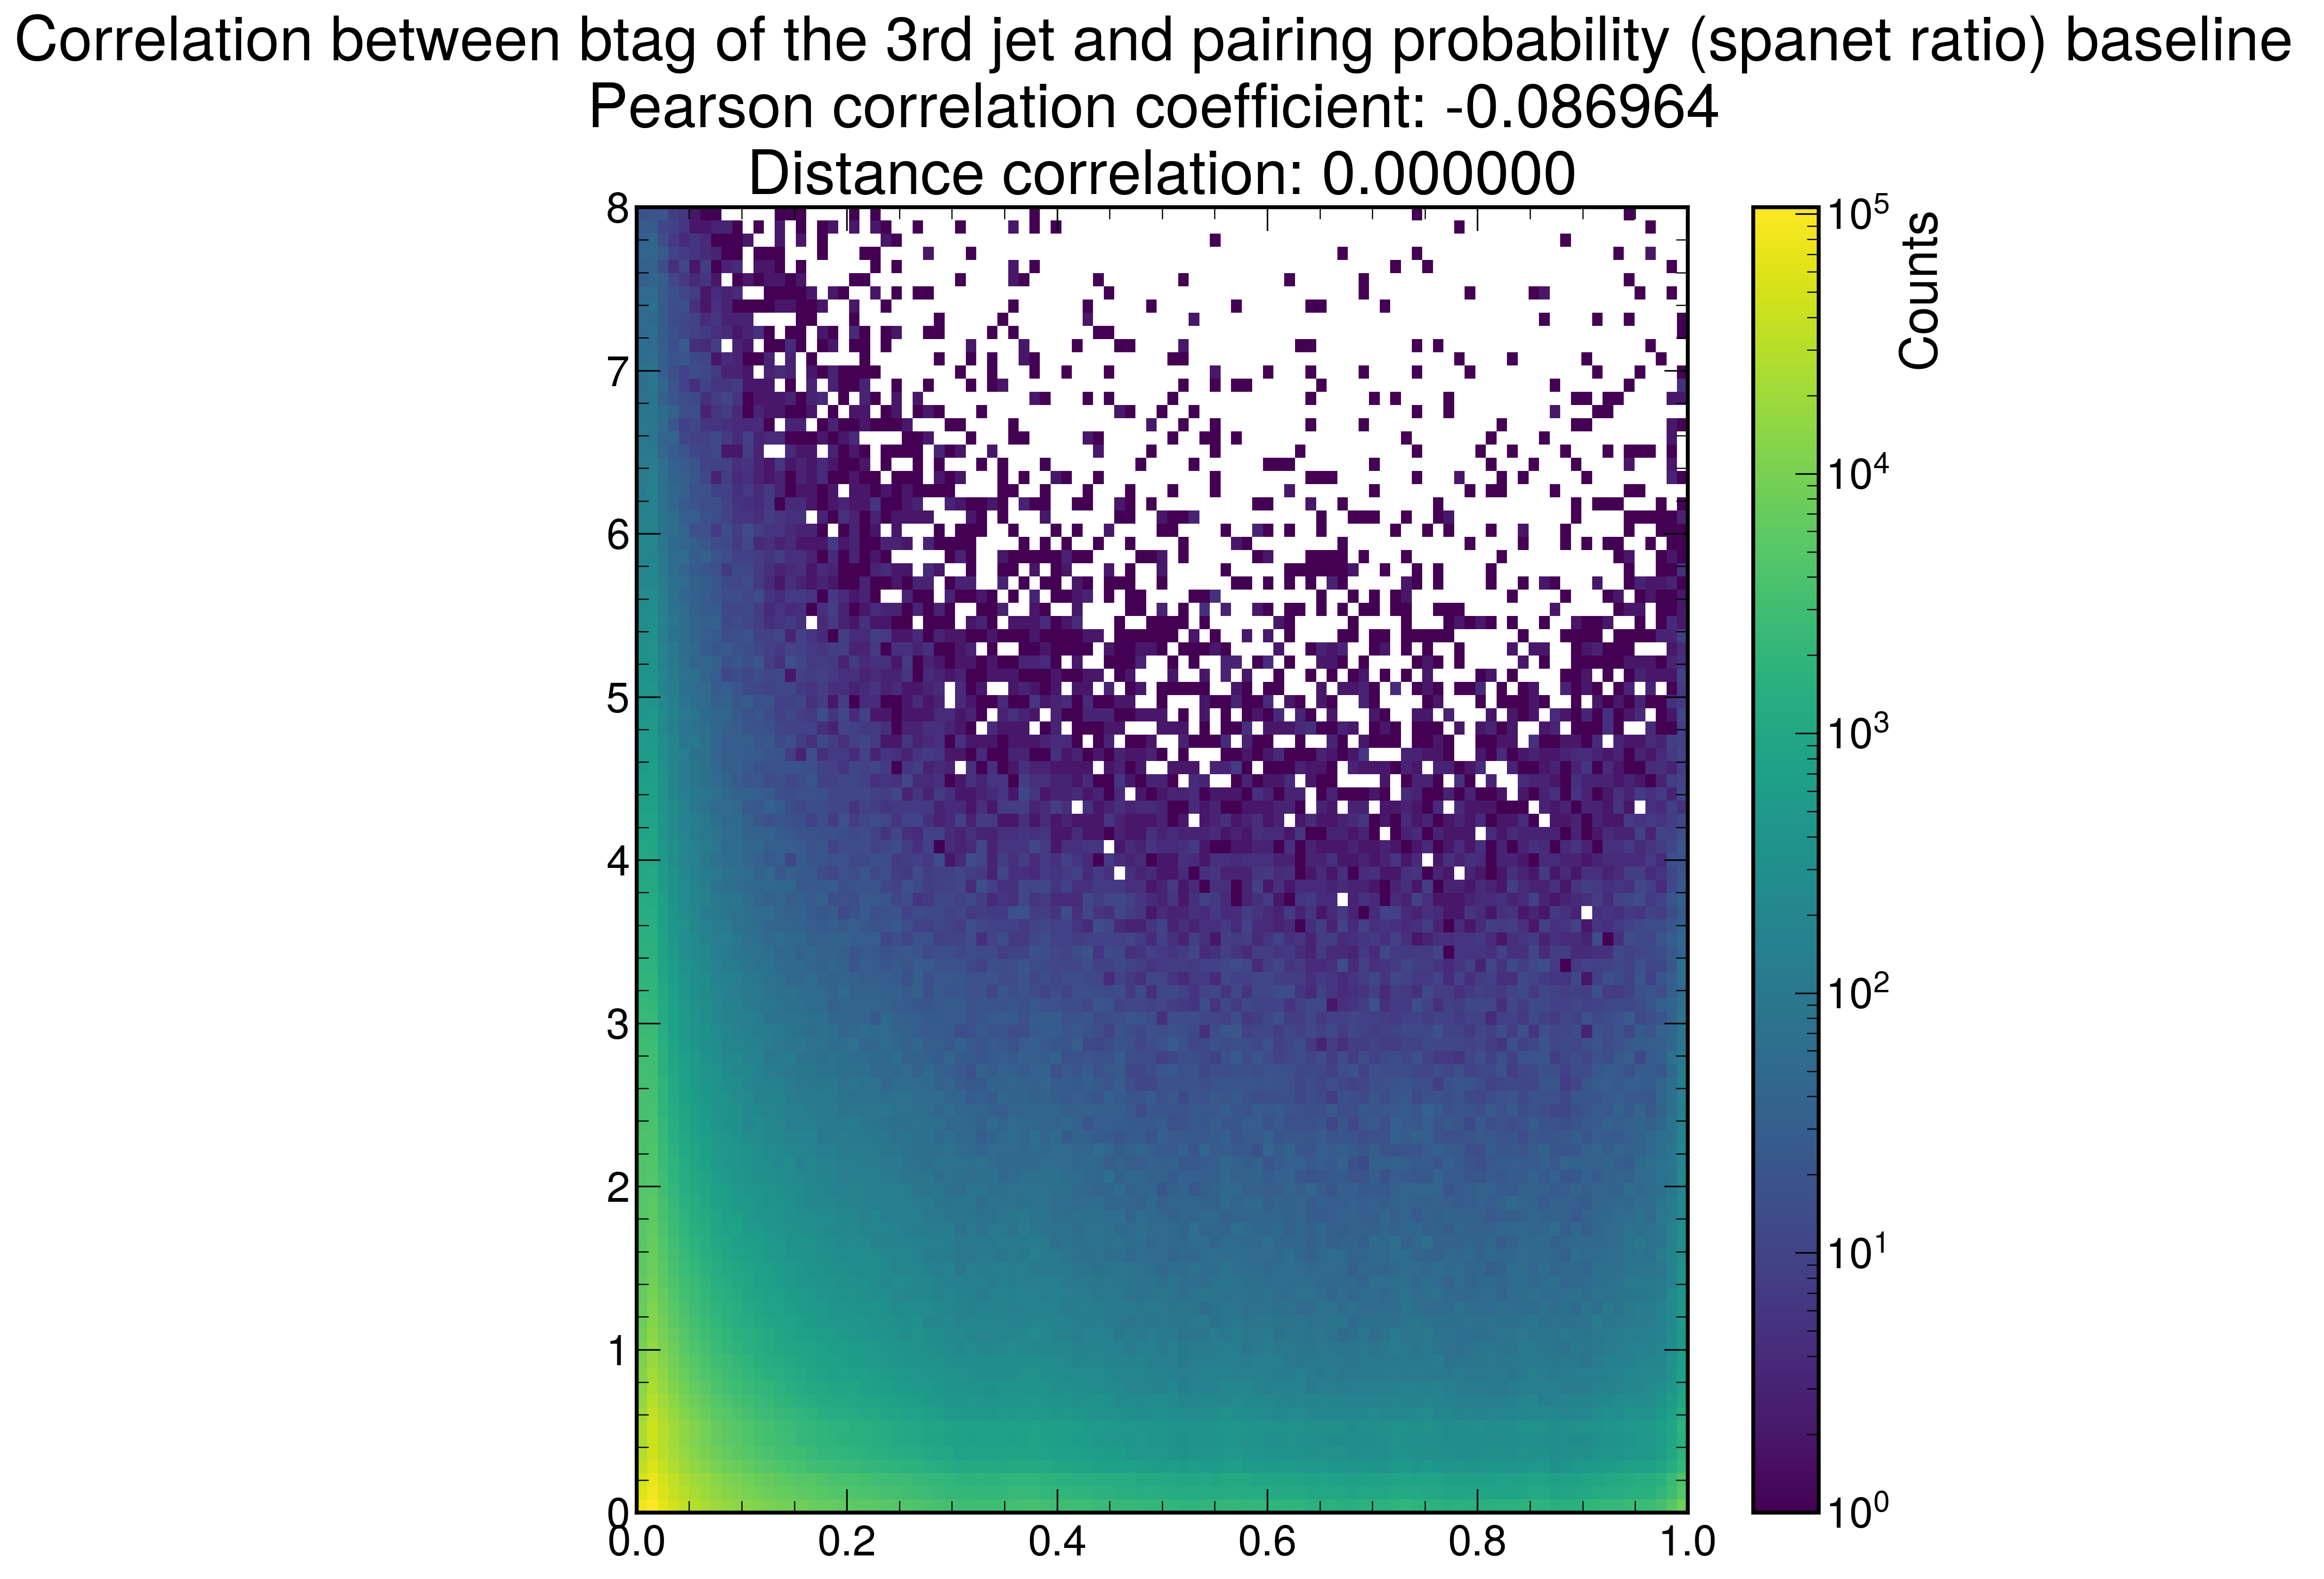

Pearson correlation coefficient (spanet ): 0.137893


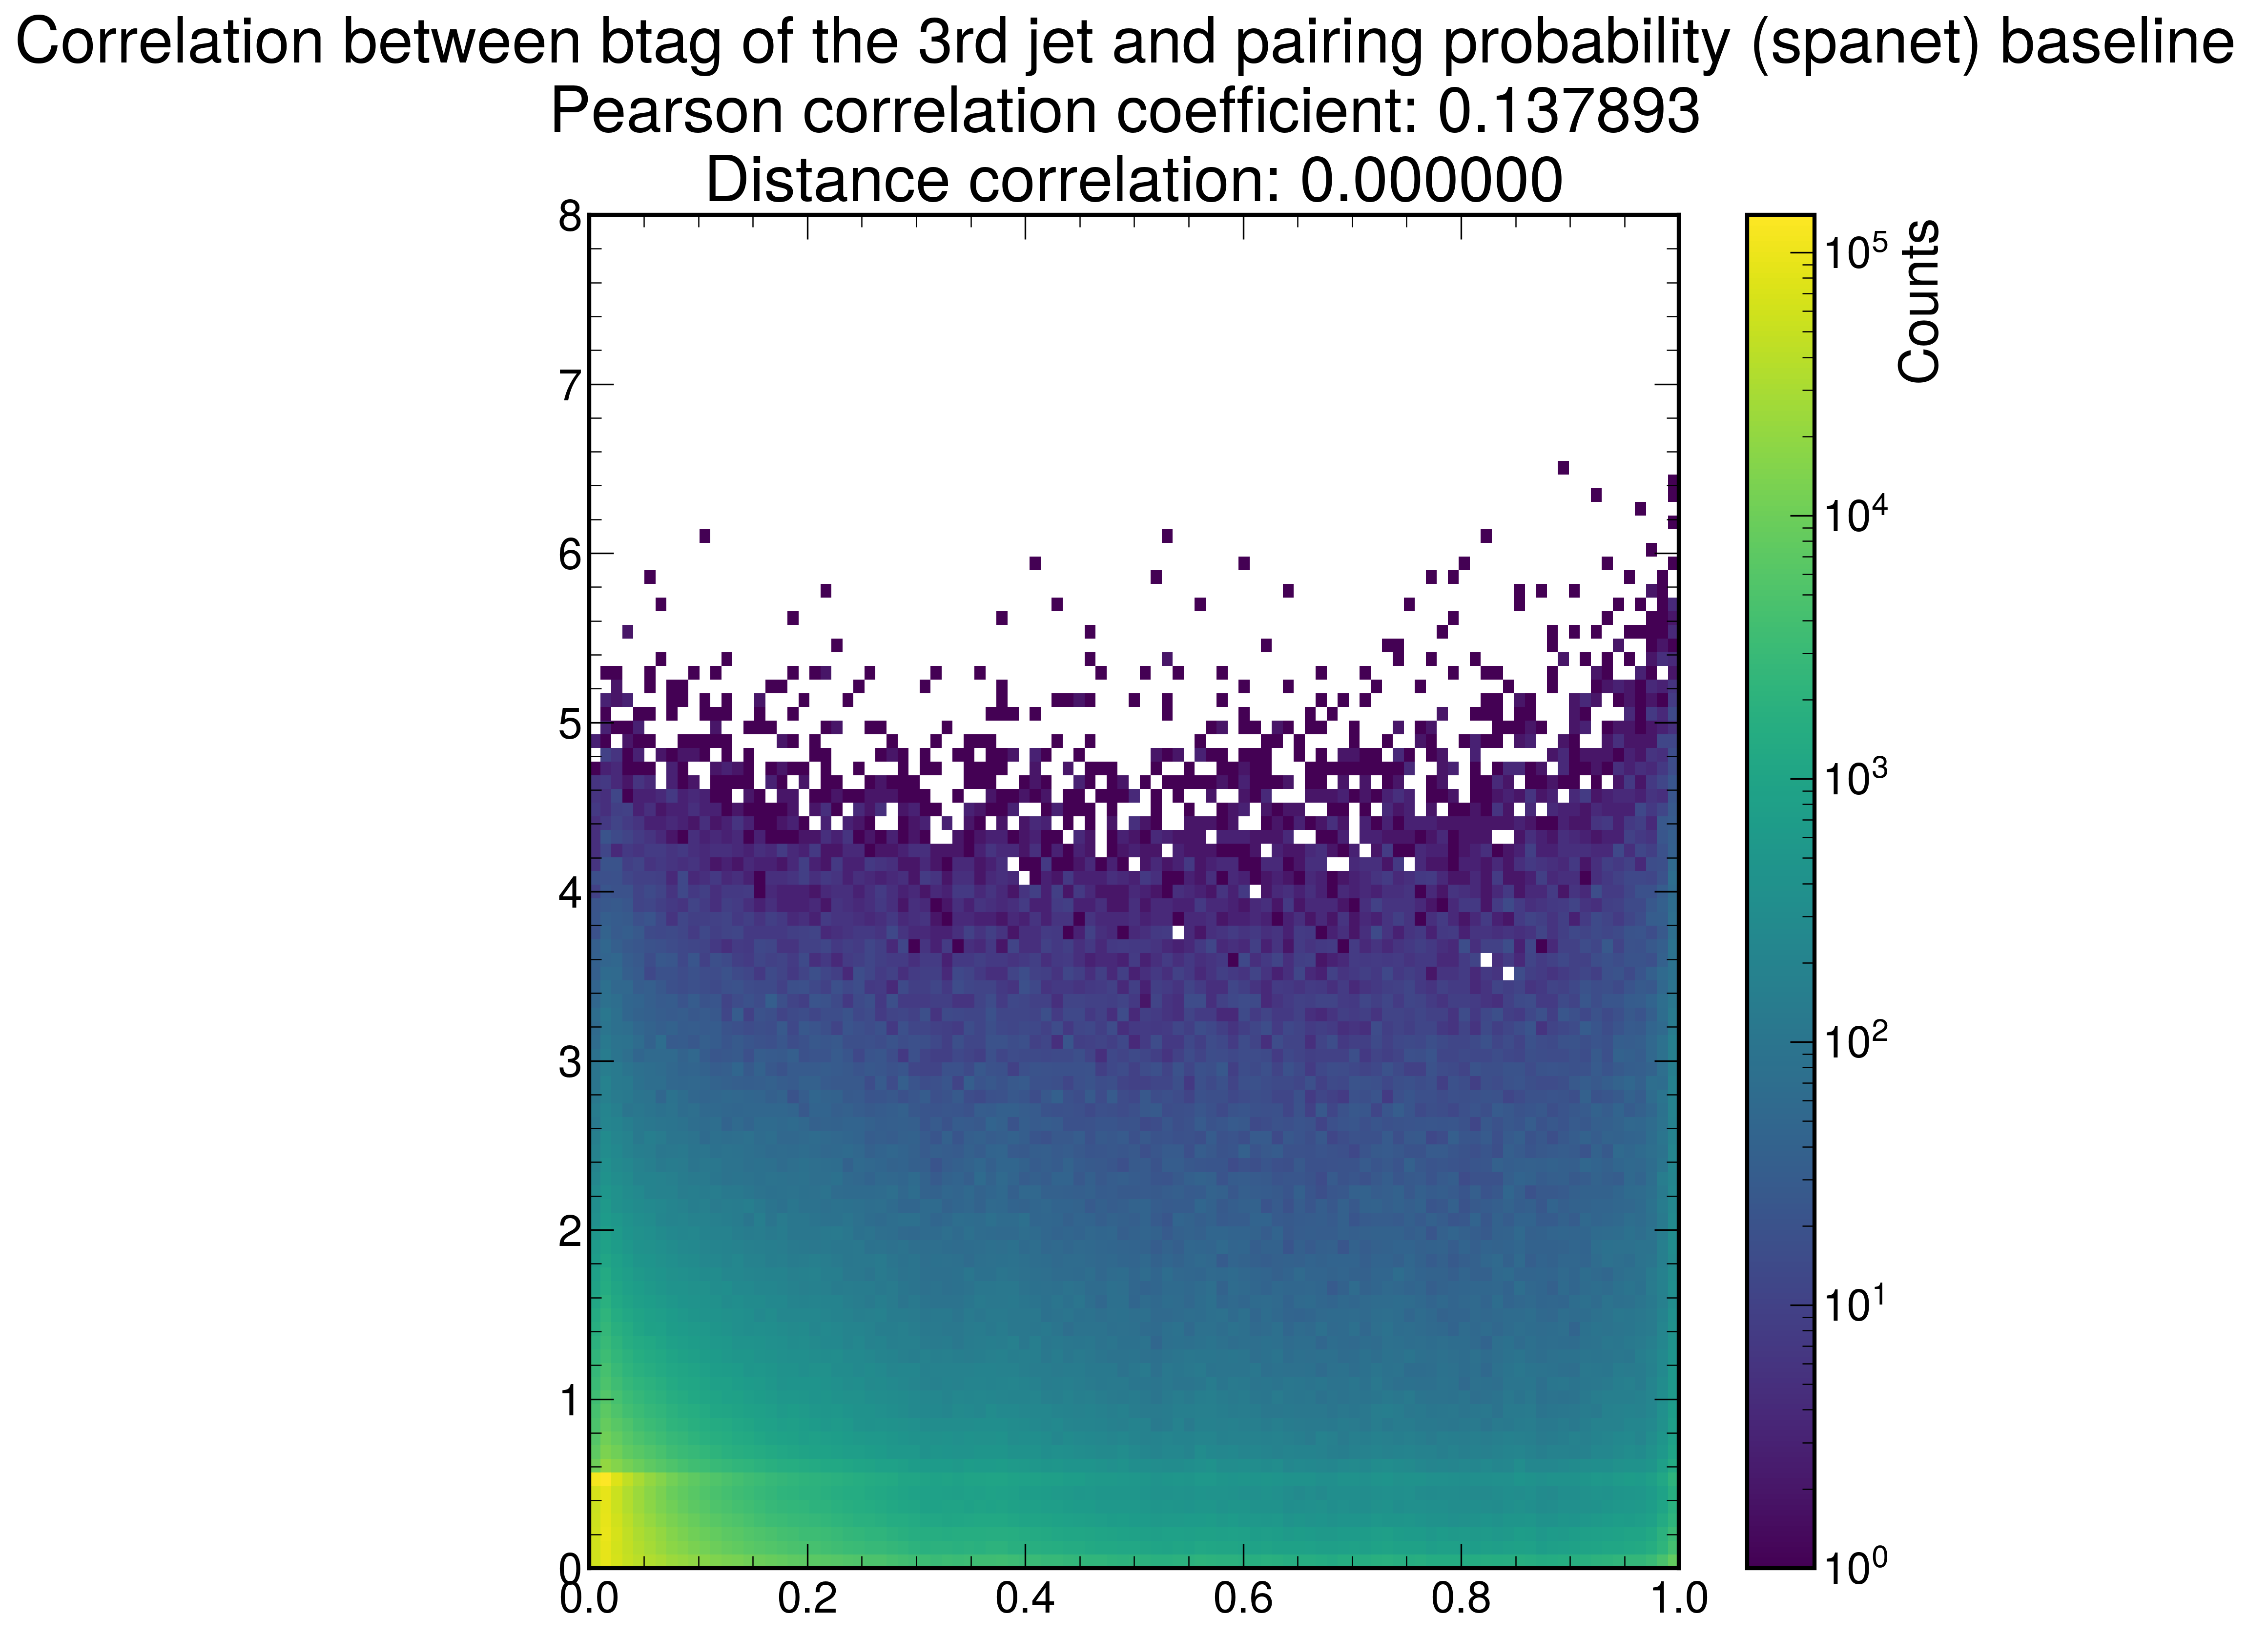

Pearson correlation coefficient (spanet ): 0.207823


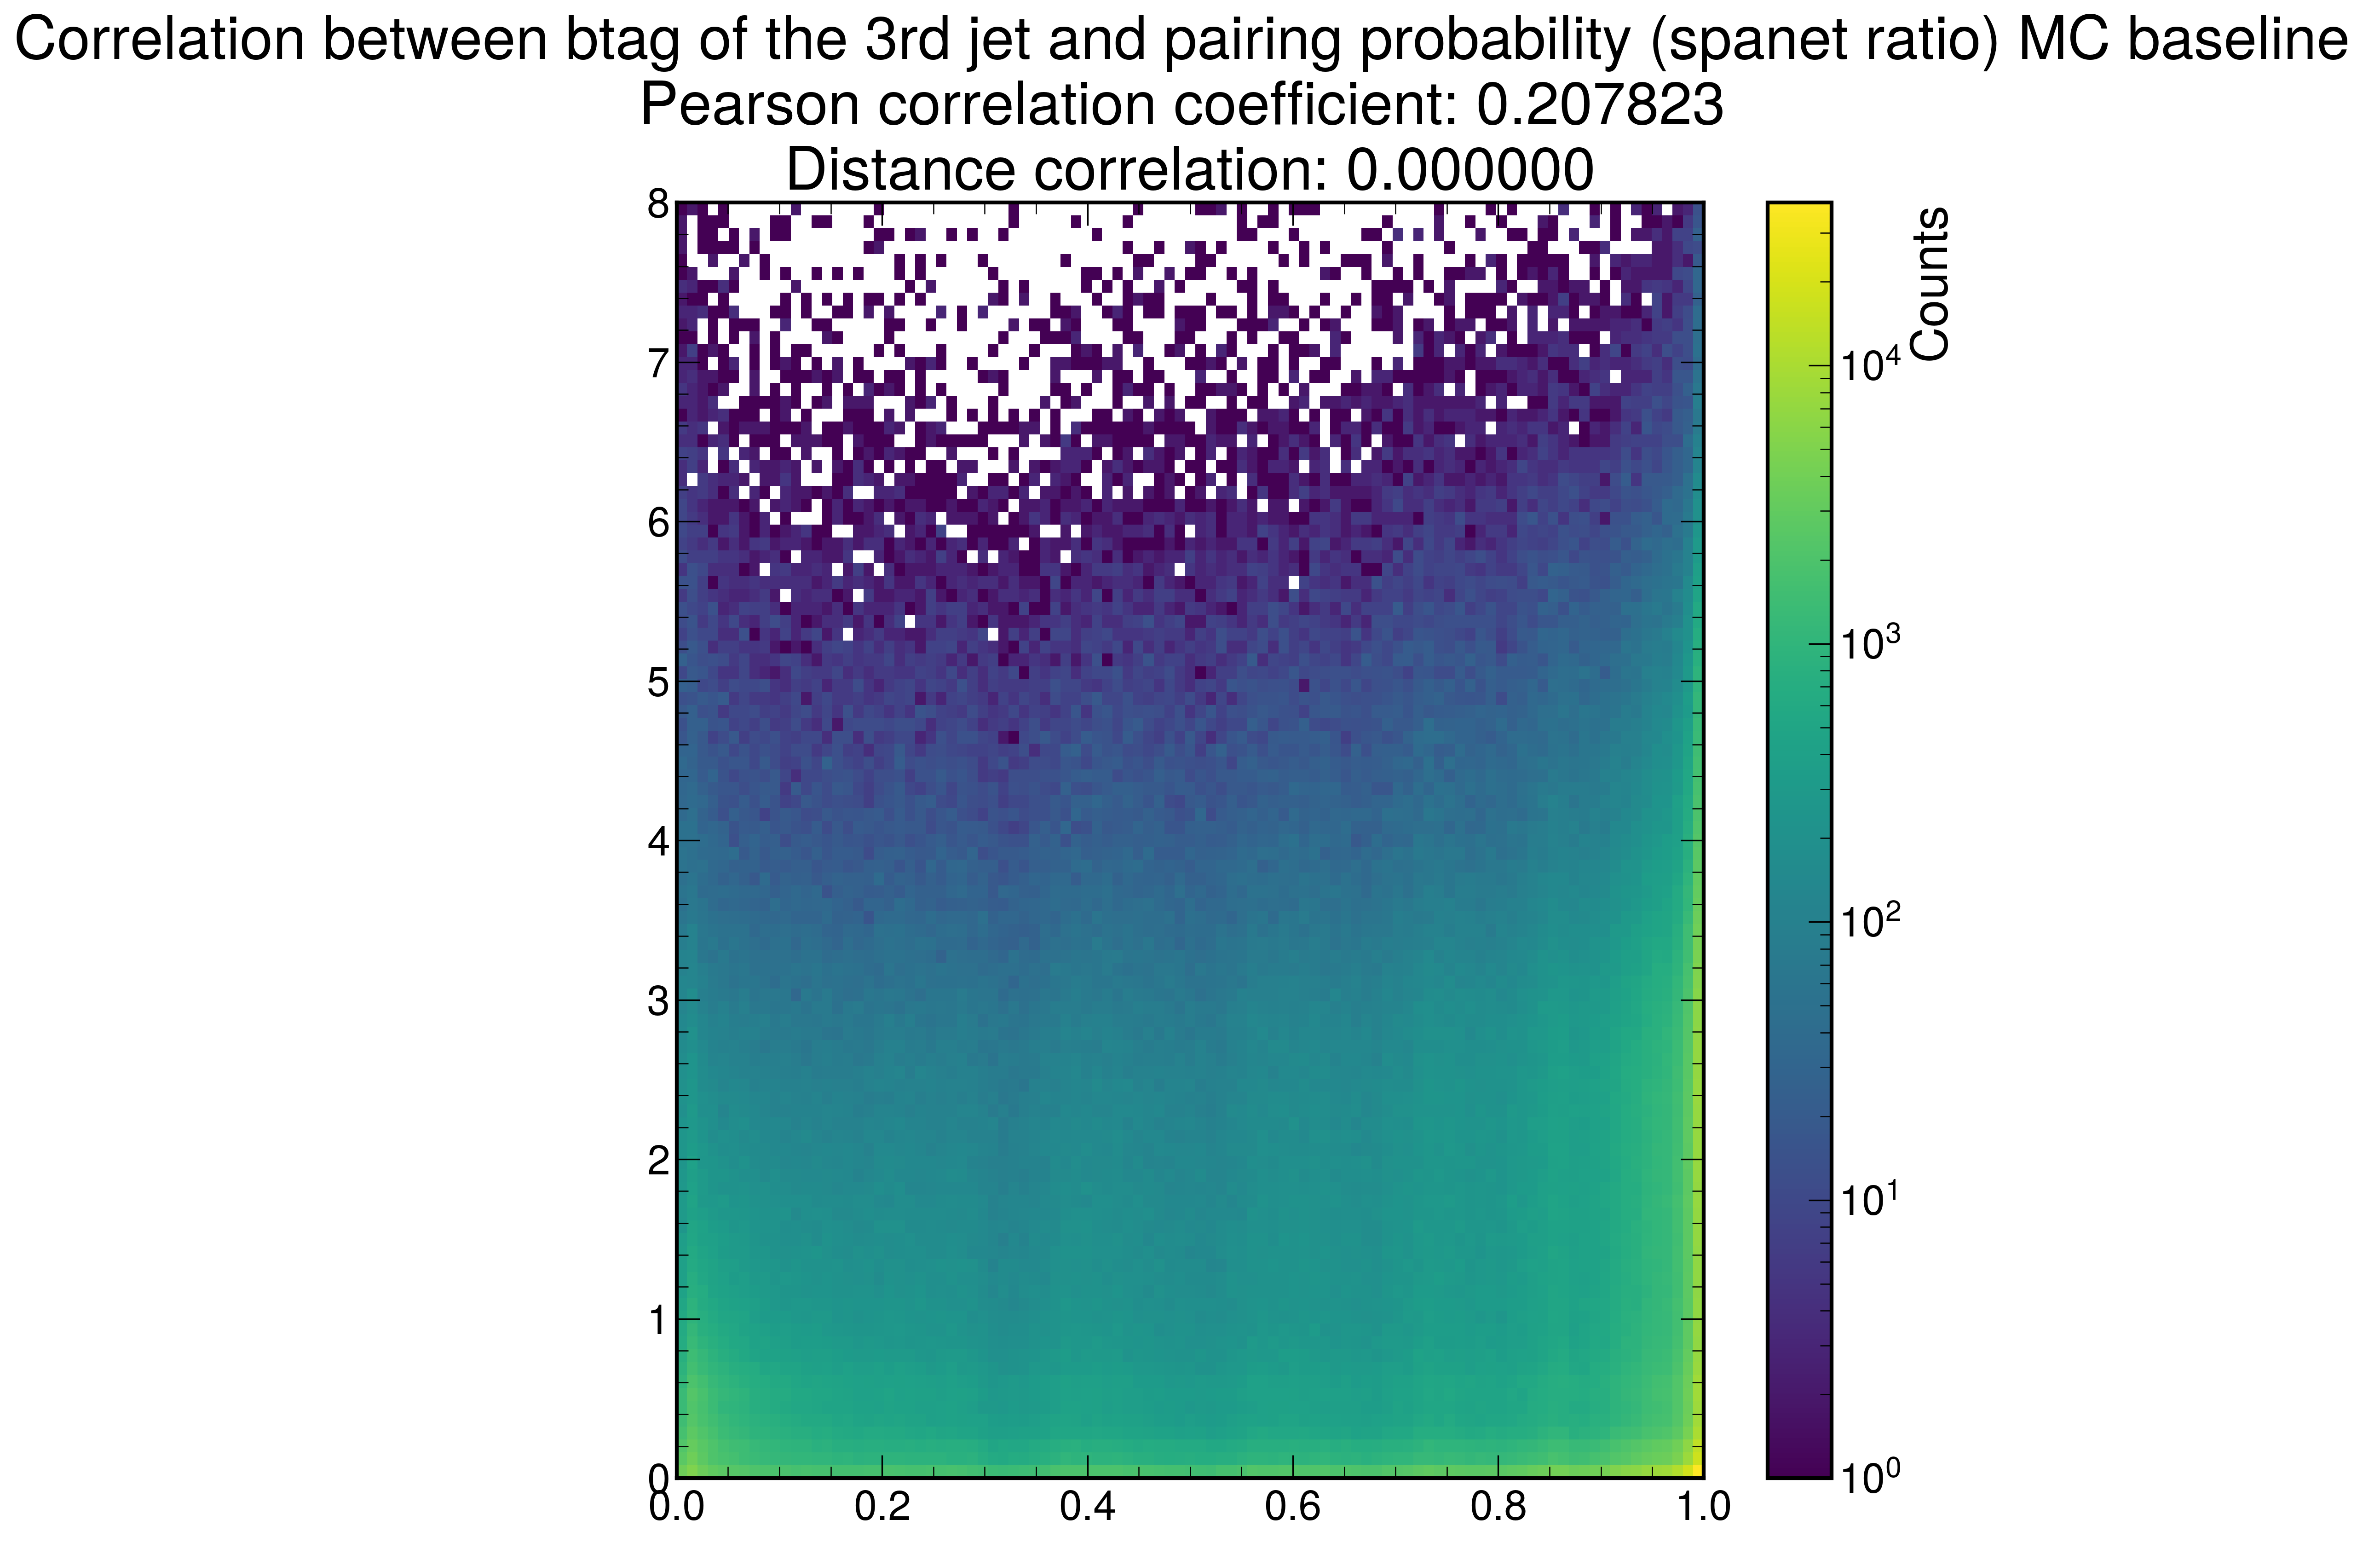

Pearson correlation coefficient (spanet ): 0.373466


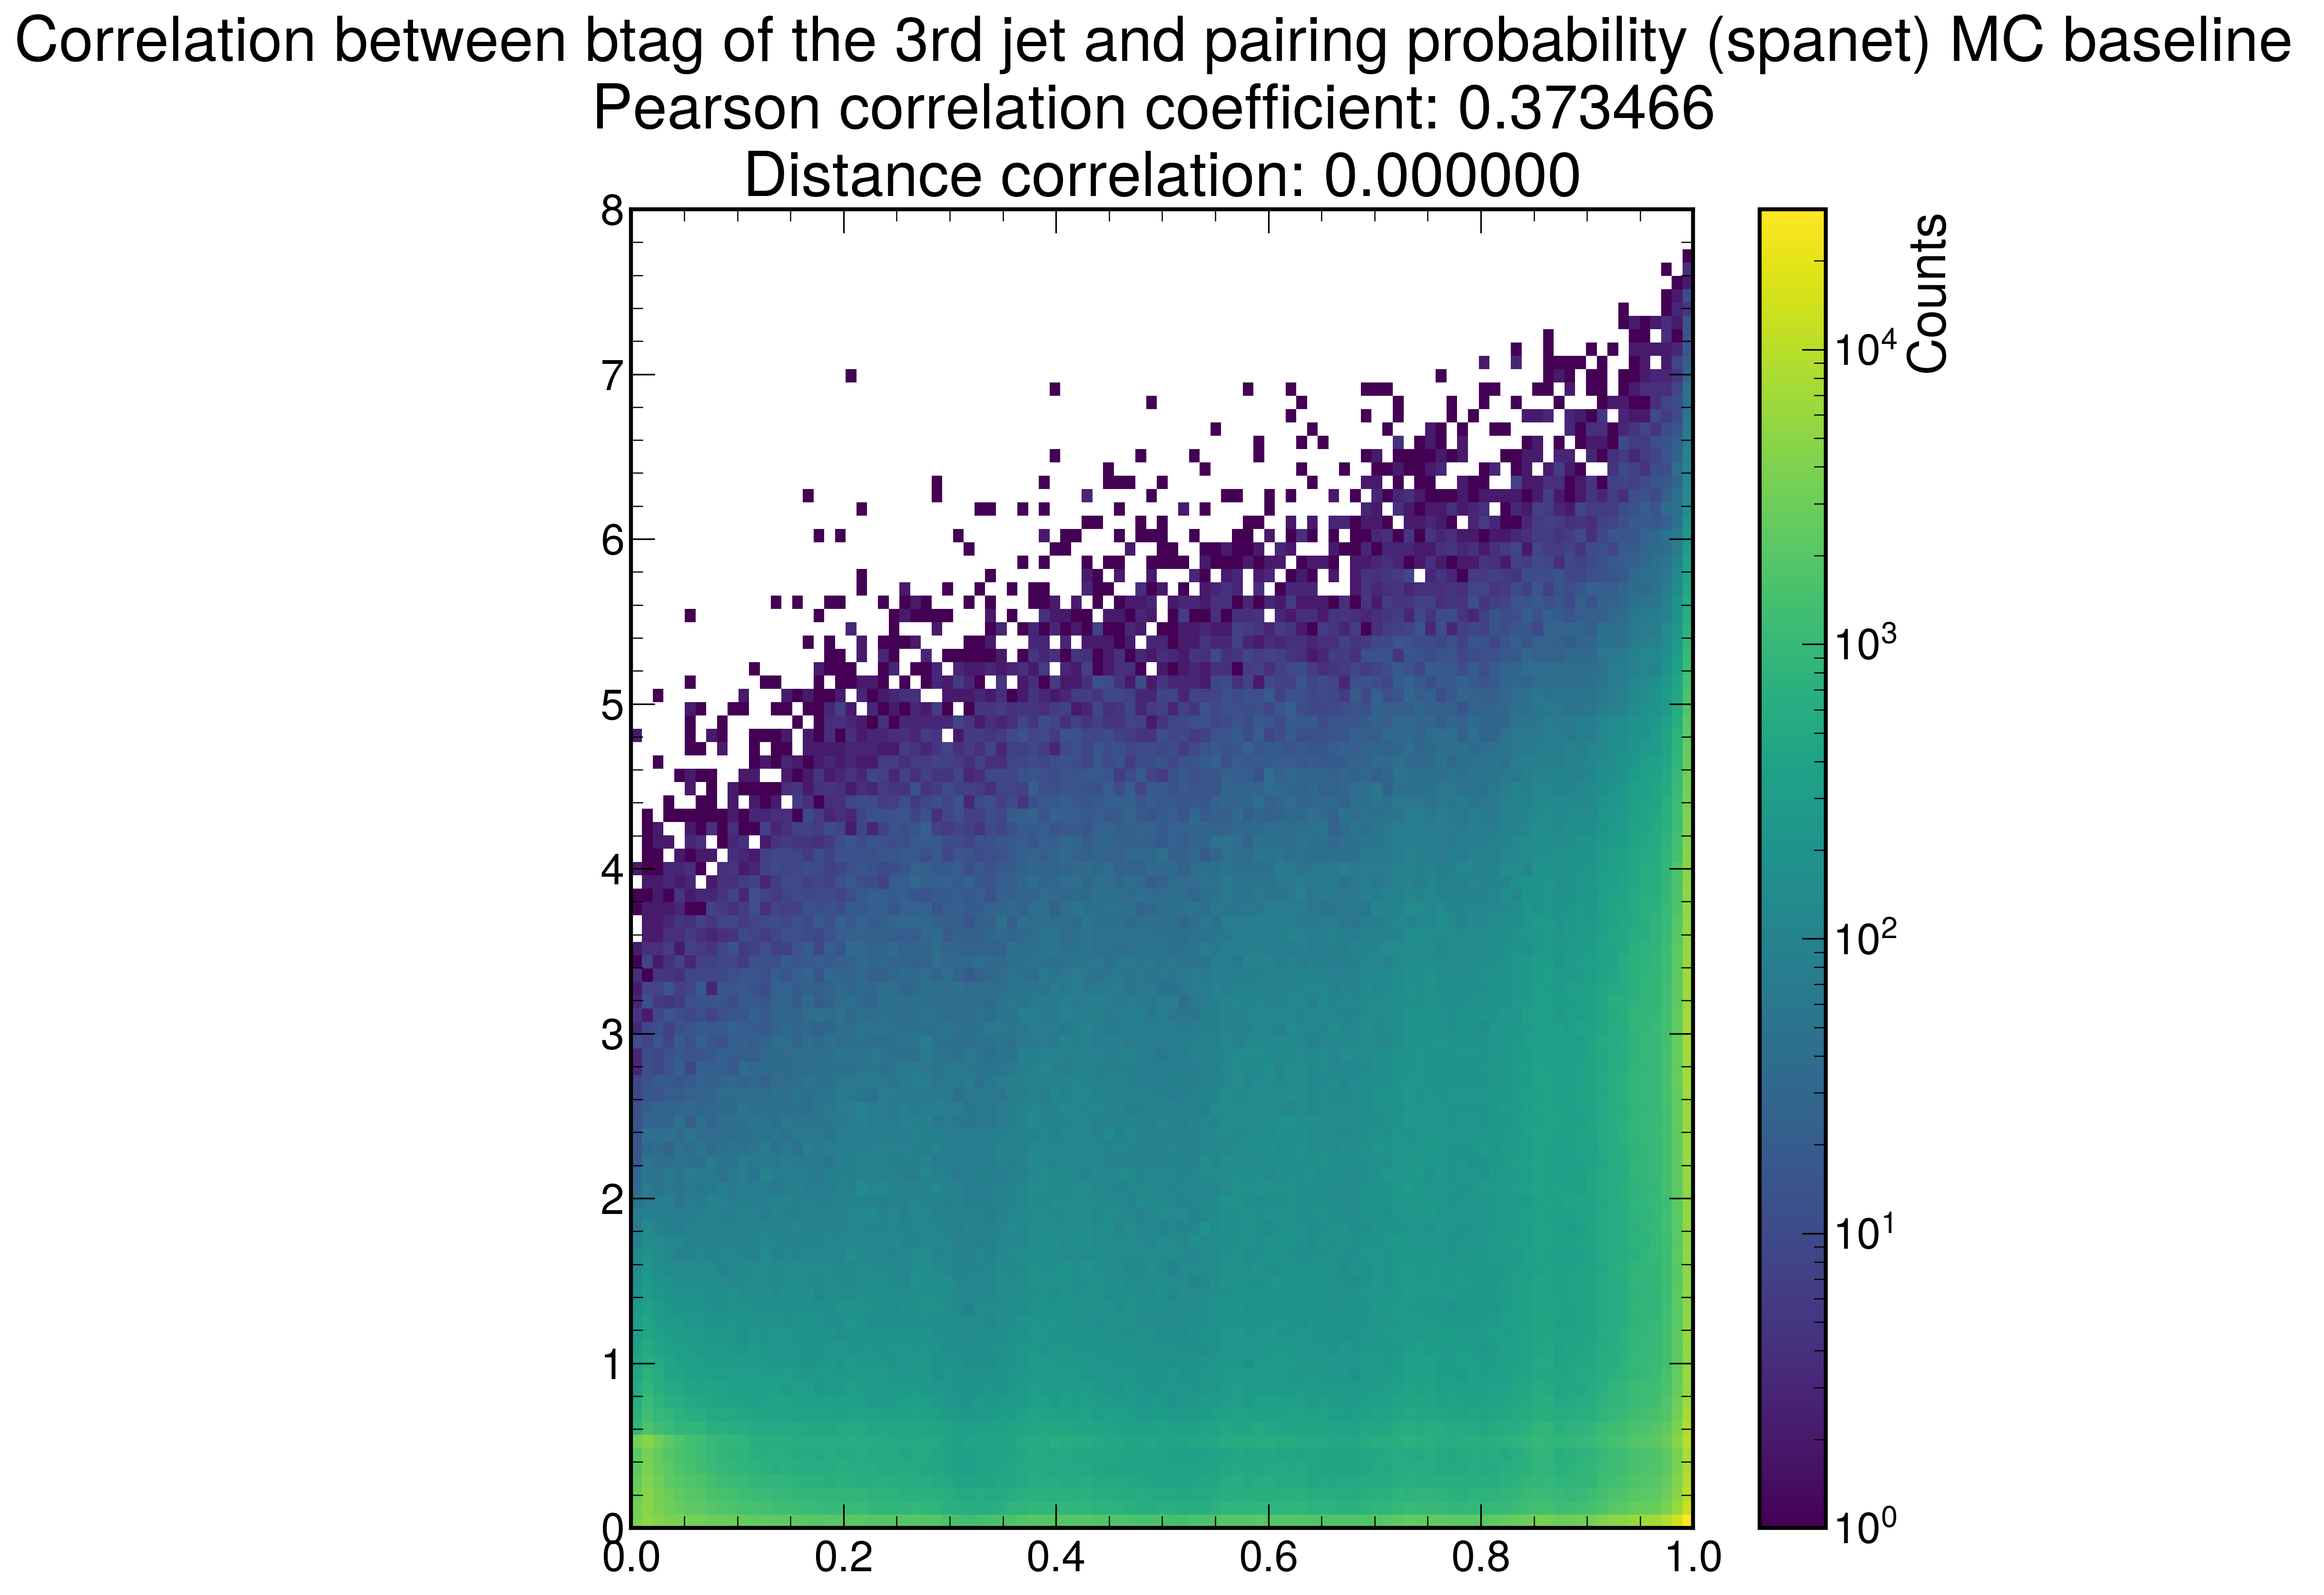

In [10]:
correlation_plot(btag_spanet_ratio_unflattened[:,2], pd_spanet_ratio, "Correlation between btag of the 3rd jet and pairing probability (spanet ratio) "+REGION)
correlation_plot(btag_spanet_unflattened[:,2], pd_spanet, "Correlation between btag of the 3rd jet and pairing probability (spanet) "+REGION)
correlation_plot(btag_spanet_ratio_mc_unflattened[:,2], pd_spanet_ratio_mc, "Correlation between btag of the 3rd jet and pairing probability (spanet ratio) MC "+REGION)
correlation_plot(btag_spanet_mc_unflattened[:,2], pd_spanet_mc, "Correlation between btag of the 3rd jet and pairing probability (spanet) MC "+REGION)


Pearson correlation coefficient (spanet ): -0.066882


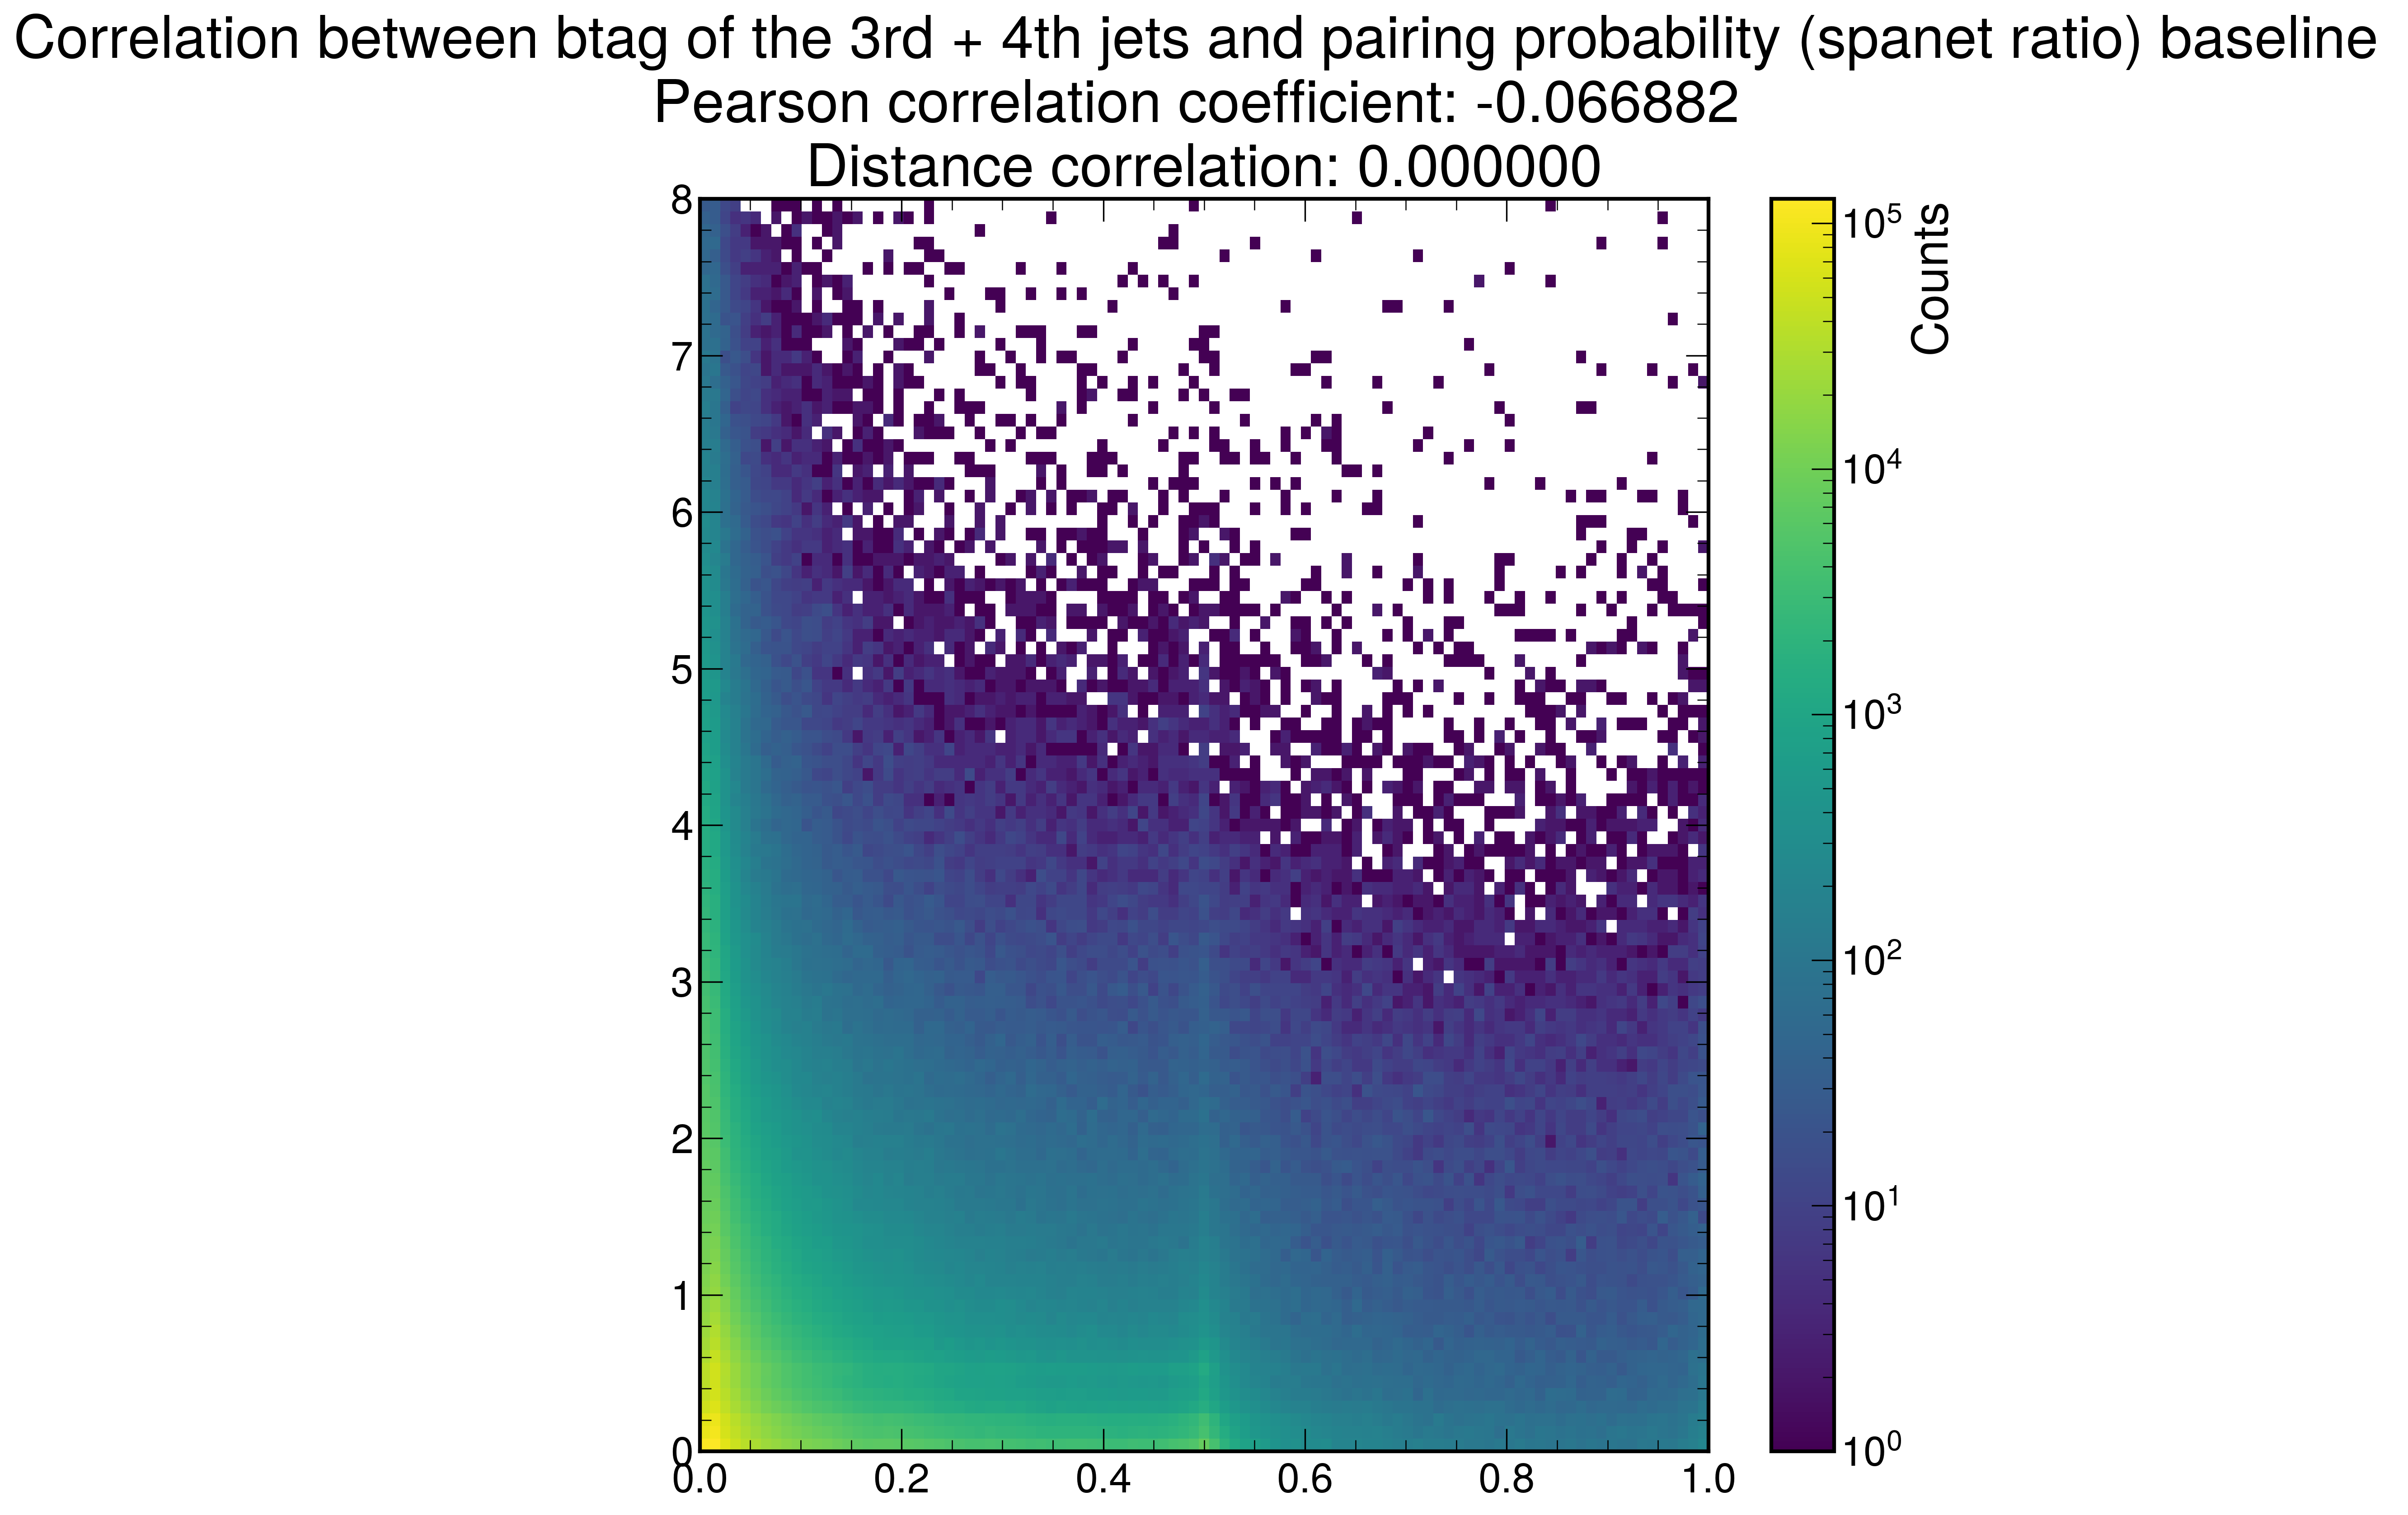

Pearson correlation coefficient (spanet ): 0.186115


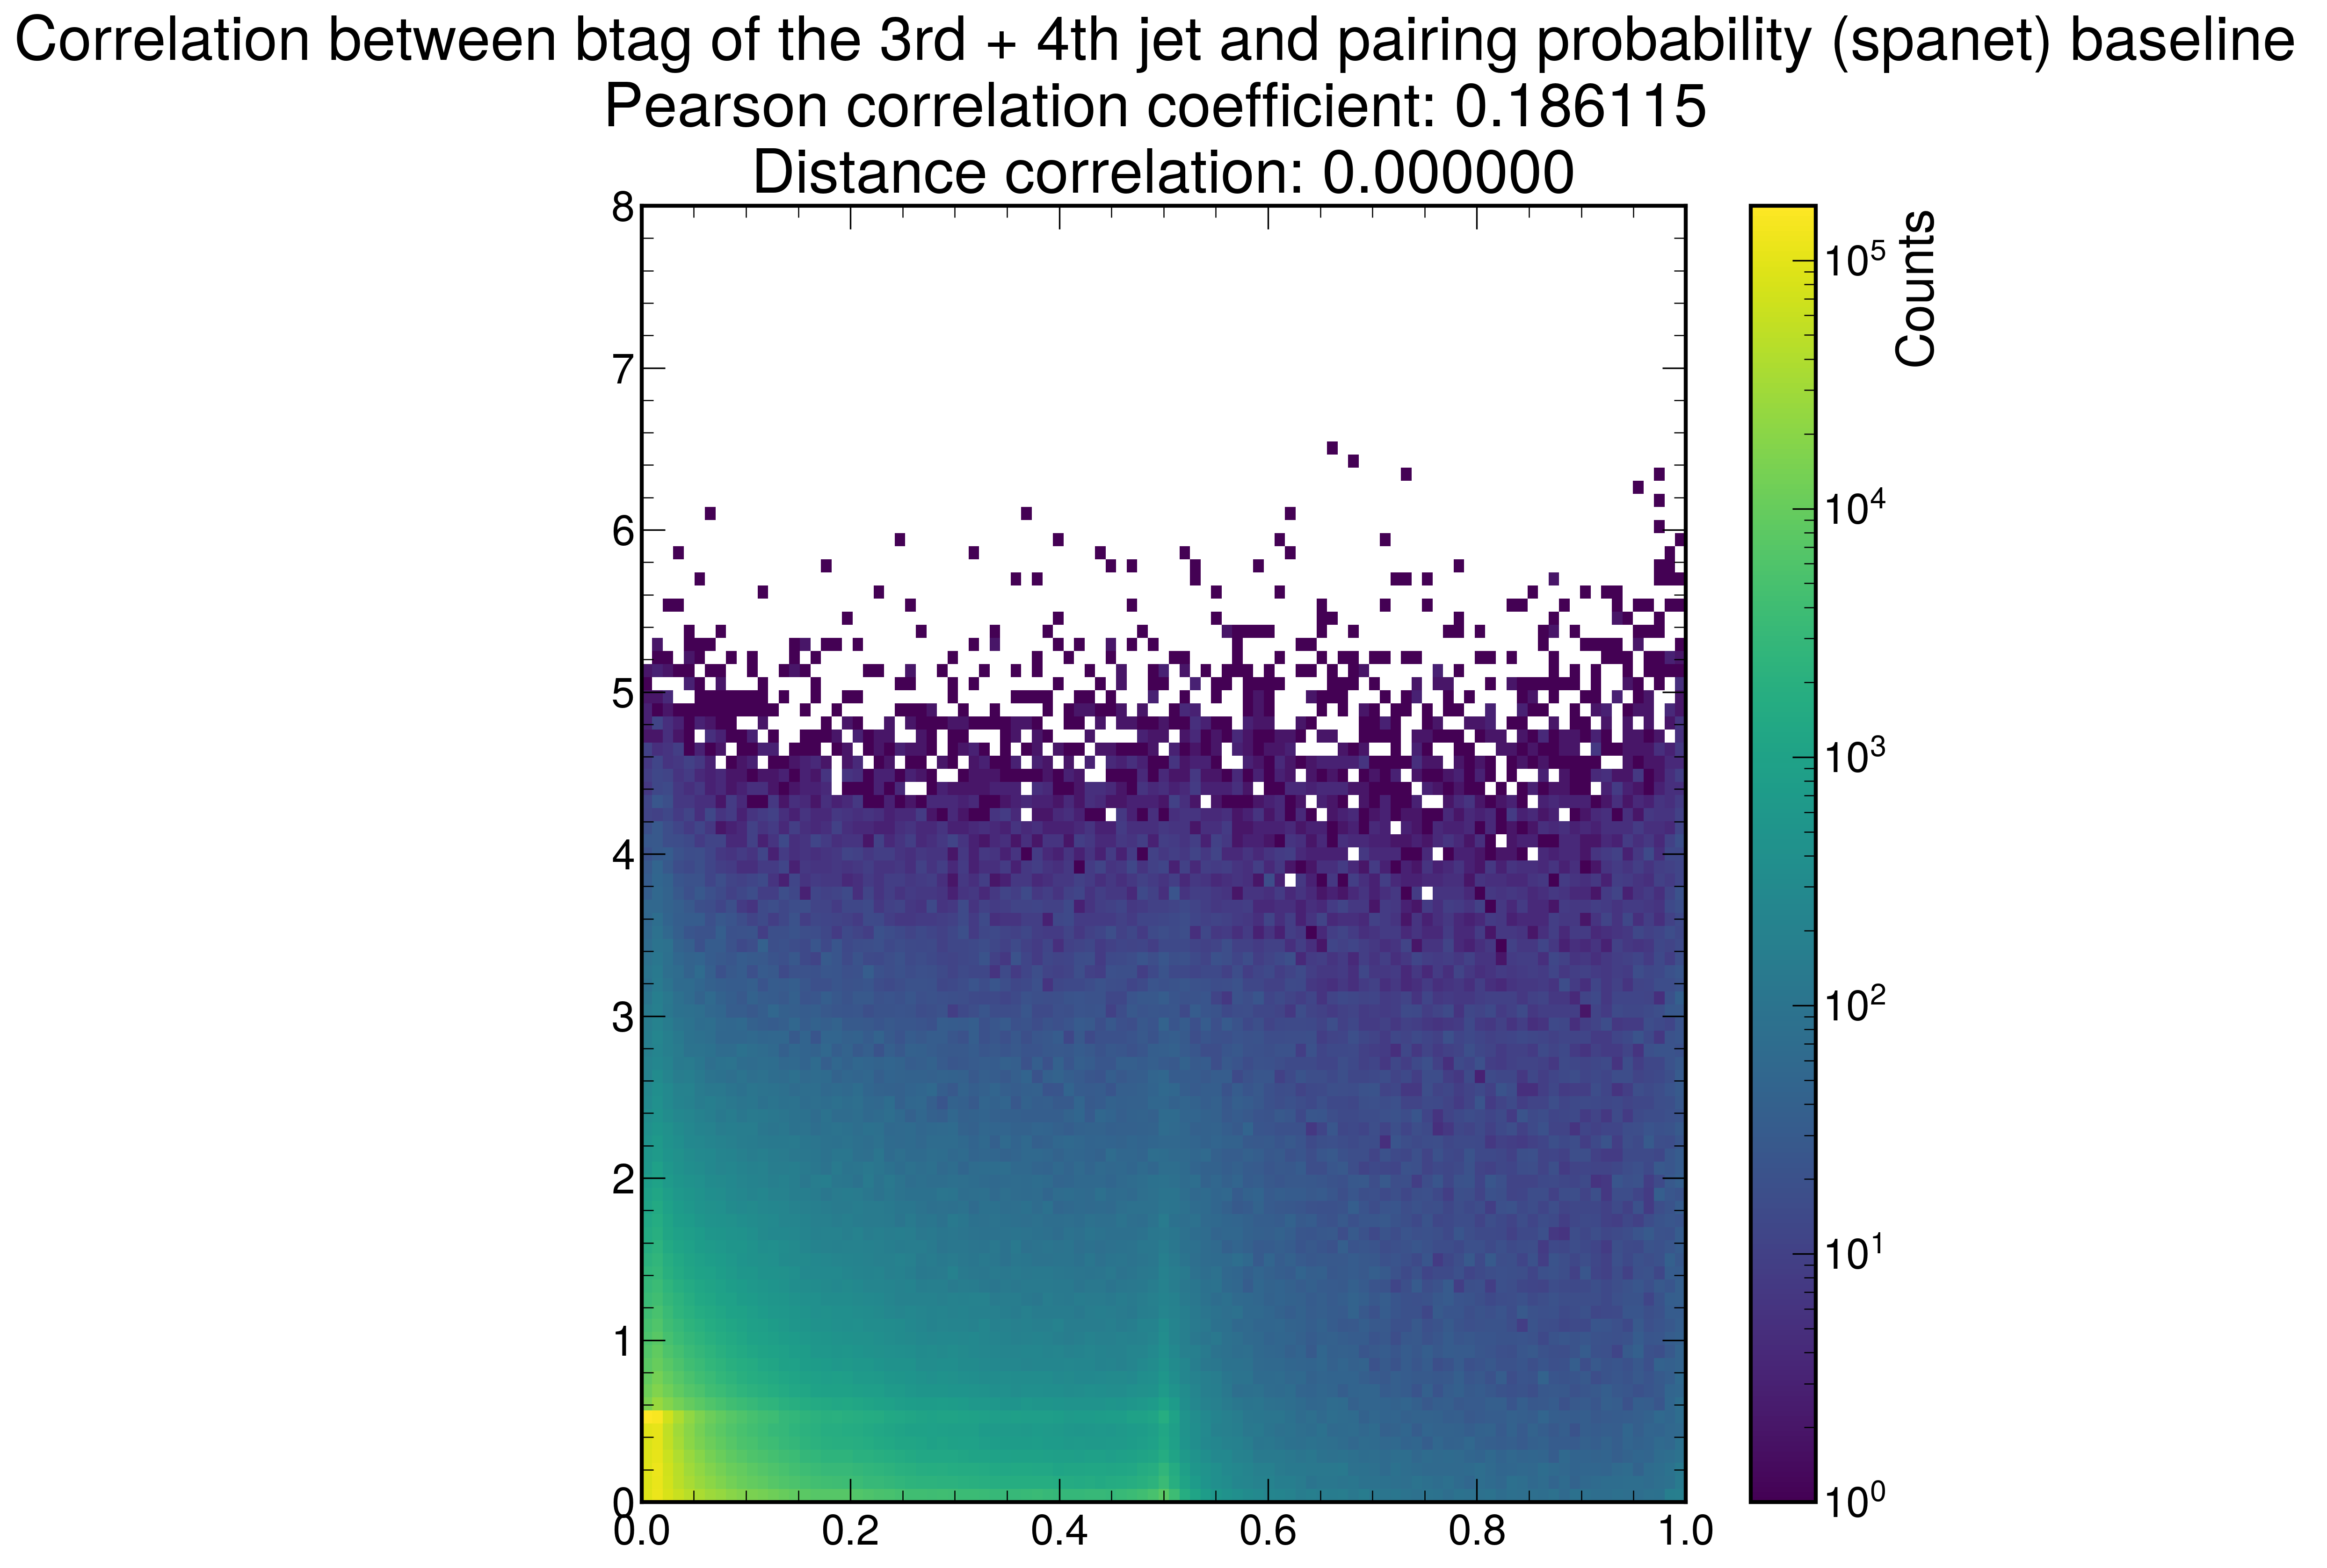

Pearson correlation coefficient (spanet ): 0.400326


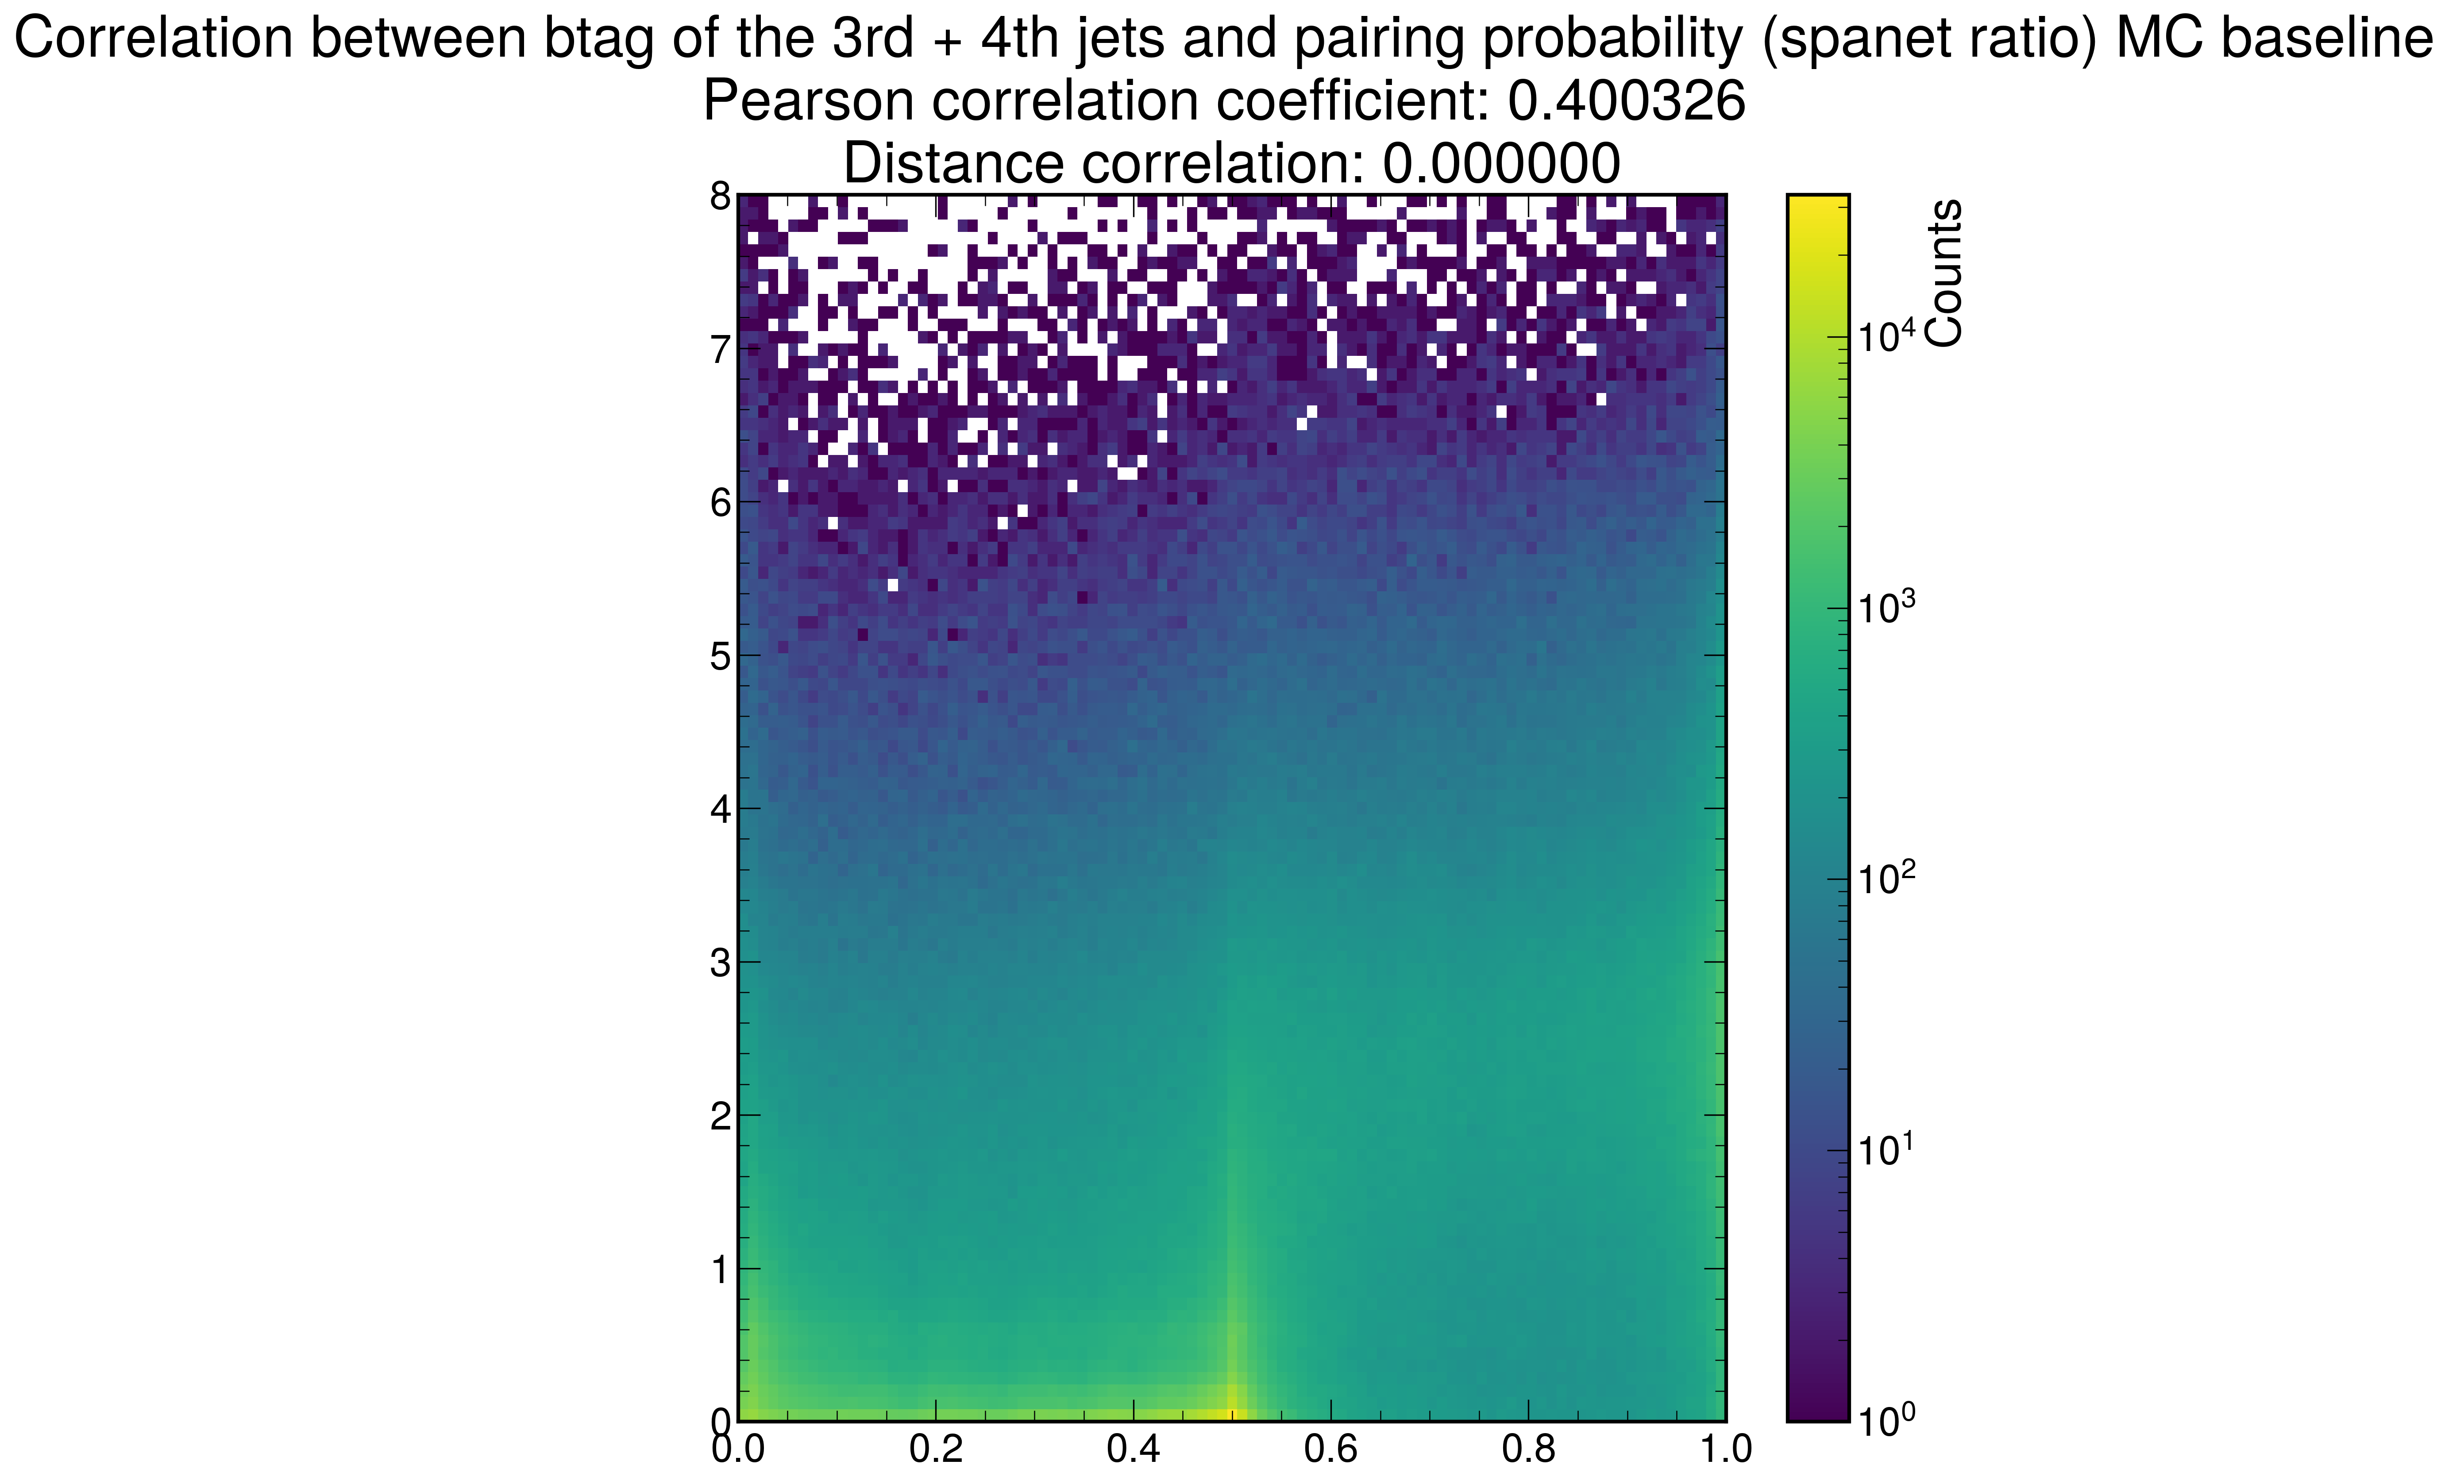

Pearson correlation coefficient (spanet ): 0.574586


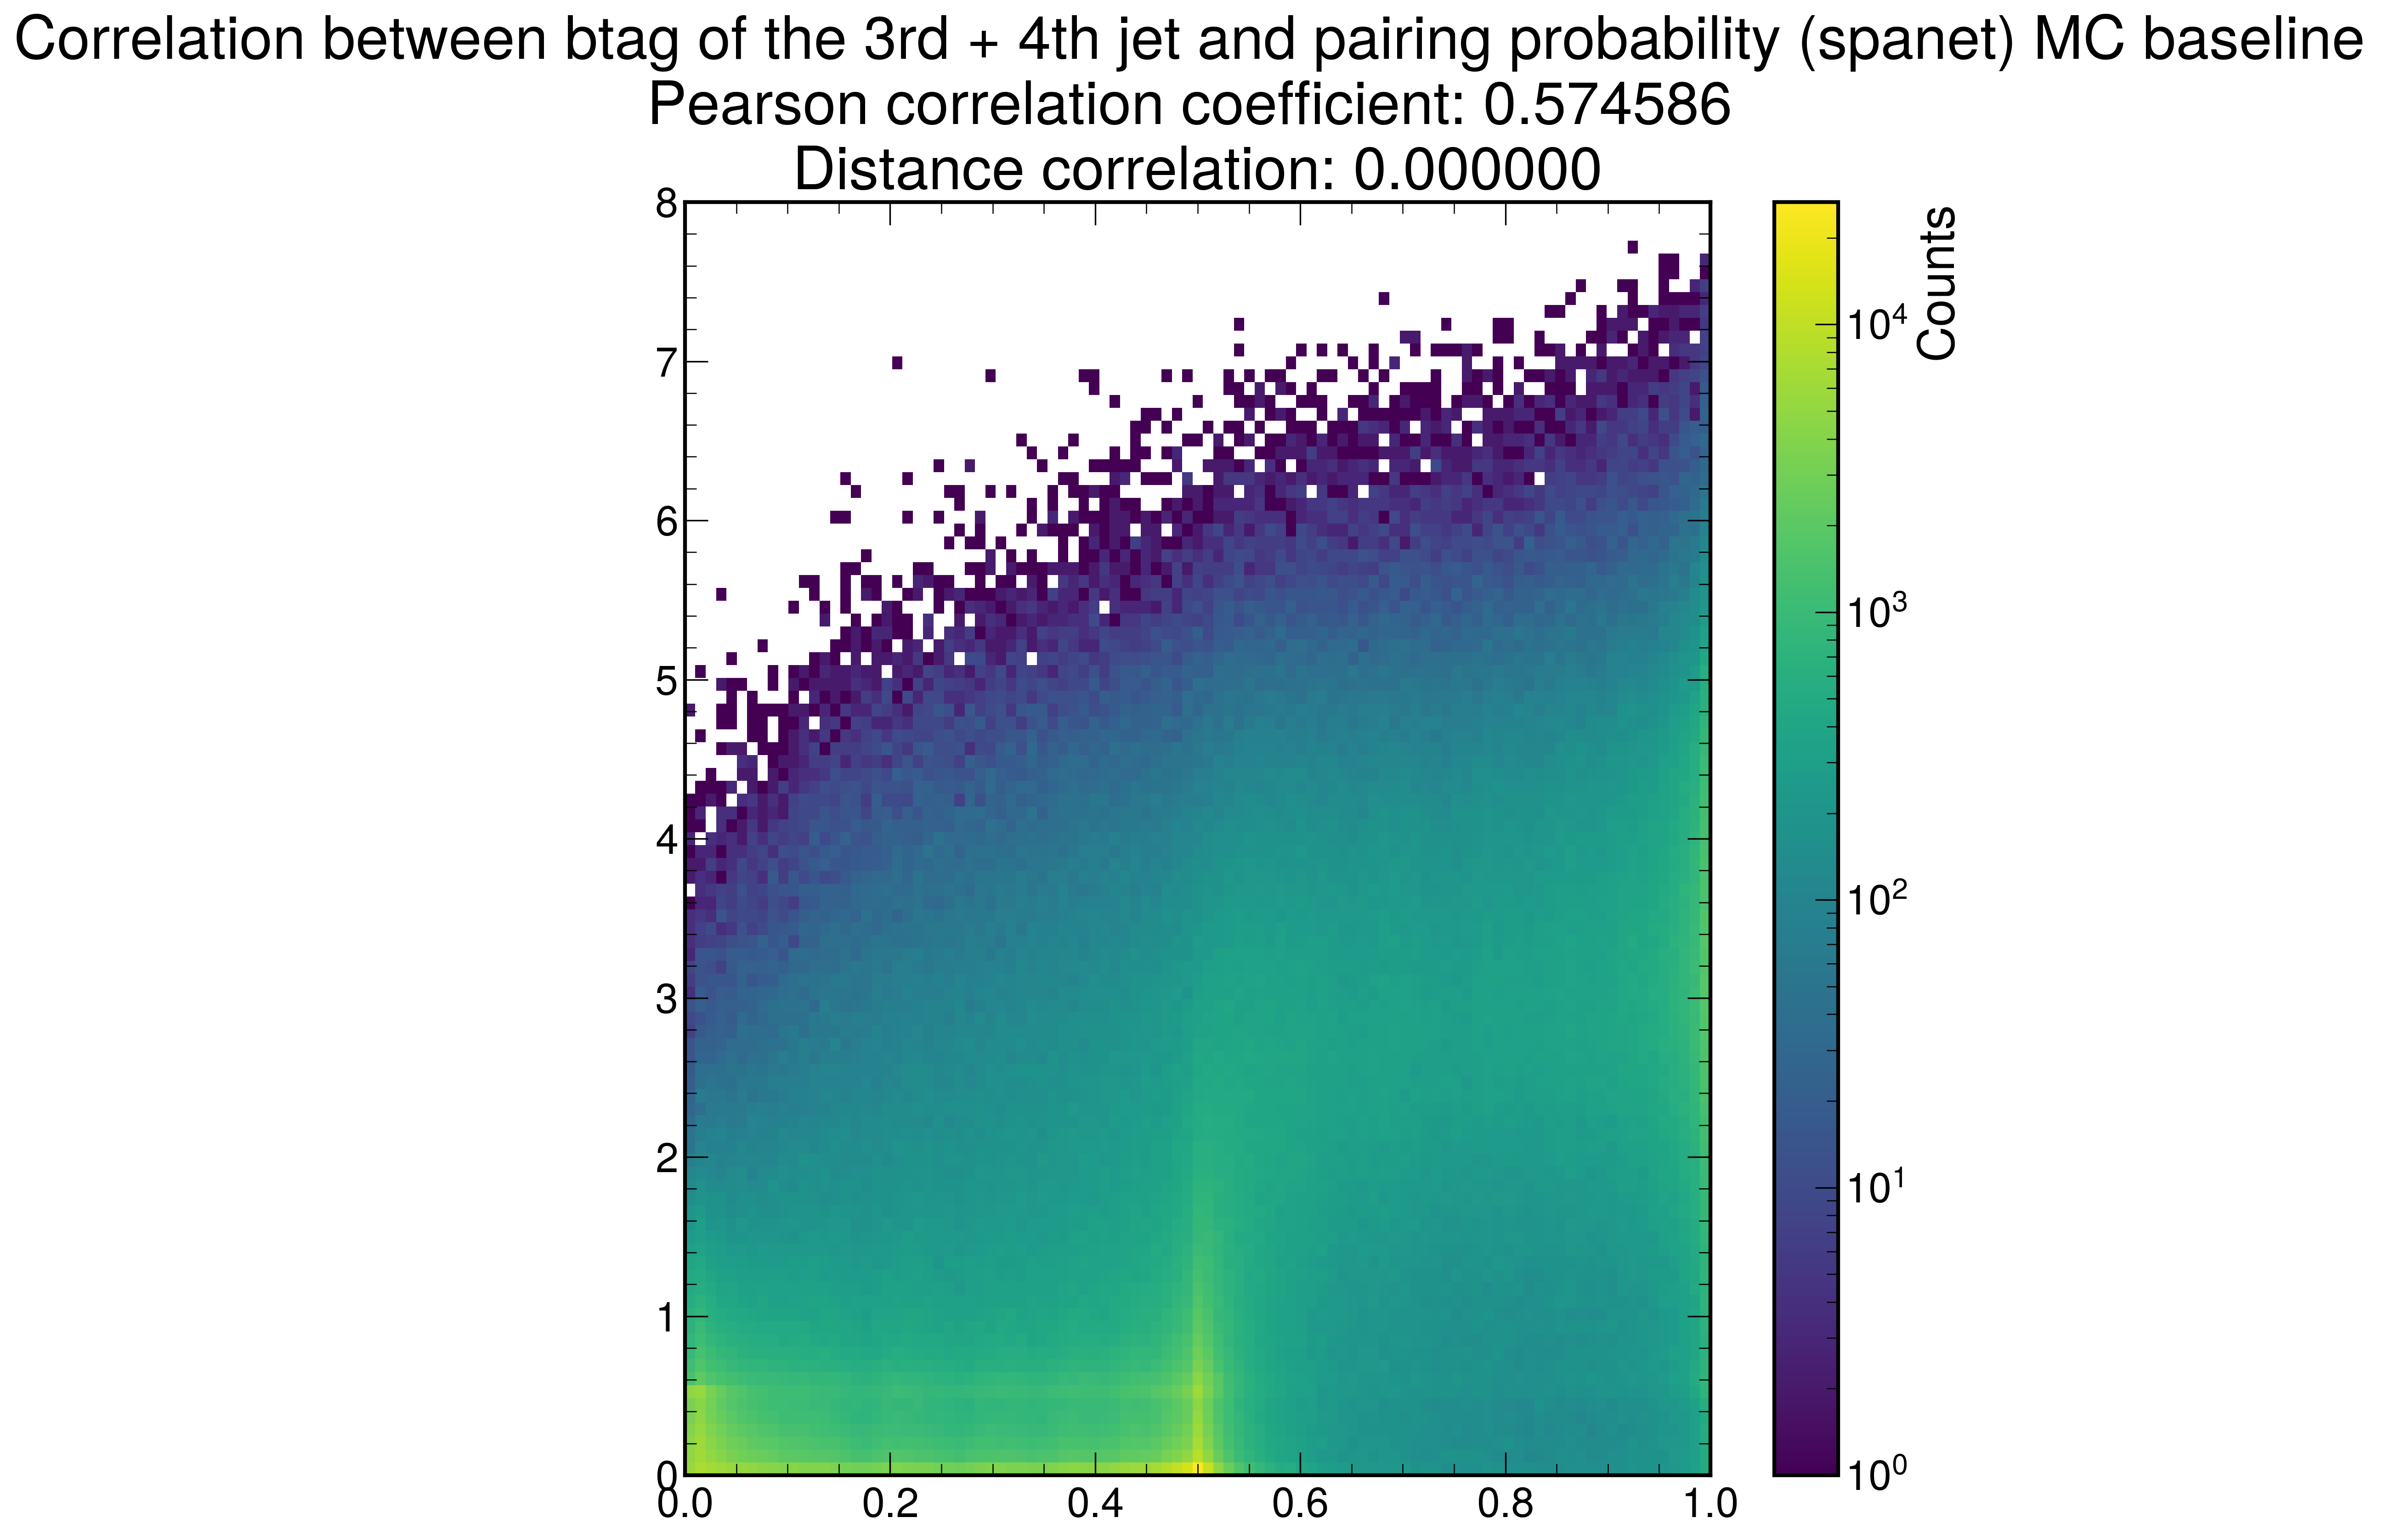

In [11]:

correlation_plot((btag_spanet_ratio_unflattened[:,2]+btag_spanet_ratio_unflattened[:,3])/2, pd_spanet_ratio, "Correlation between btag of the 3rd + 4th jets and pairing probability (spanet ratio) "+REGION)
correlation_plot((btag_spanet_unflattened[:,2]+btag_spanet_unflattened[:,3])/2, pd_spanet, "Correlation between btag of the 3rd + 4th jet and pairing probability (spanet) "+REGION)
correlation_plot((btag_spanet_ratio_mc_unflattened[:,2]+btag_spanet_ratio_mc_unflattened[:,3])/2, pd_spanet_ratio_mc, "Correlation between btag of the 3rd + 4th jets and pairing probability (spanet ratio) MC "+REGION)
correlation_plot((btag_spanet_mc_unflattened[:,2]+btag_spanet_mc_unflattened[:,3])/2, pd_spanet_mc, "Correlation between btag of the 3rd + 4th jet and pairing probability (spanet) MC "+REGION)


In [13]:
if False:
    x = np.linspace(0, 1, 100)
    y=2*x+np.random.normal(0, 10000, 100)

    # compute the correlation between x and y
    corr, _ = pearsonr(x, y)
    corr_np=np.corrcoef(x,y)
    print(f"Pearson correlation coefficient (x, y): {corr:.6f}")

    print(f"Pearson correlation coefficient (x, y) numpy: {corr_np[0,1]:.6f}")

    disco=distance_correlation(x, y)
    print(f"Distance correlation (x, y): {disco:.6f}")

# Prob Diff correlation DNN score

In [14]:
input_file='/work/mmalucch/out_hh4b/SigBkg/out_2022postEE_spanet_pt_vary_bratio_all_bkgMorphing_SvB/output_DATA_JetMET_JMENano_G_2022_postEE_EraG.coffea'
col_bkg_dnn_bratio = get_cols_from_file(input_file, "4b_signal_region")

sample: DATA_JetMET_JMENano_G_skimmed, dataset: DATA_JetMET_JMENano_G_2022_postEE_EraG categories: ['4b_region', '4b_control_region', '2b_control_region_preW', '4b_signal_region_blind', '4b_signal_region', '2b_signal_region_preW_blind', '2b_signal_region_preW', '2b_control_region_postW', '2b_signal_region_postW_blind', '2b_signal_region_postW']


In [15]:
input_file='/work/mmalucch/out_hh4b/SigBkg/out_2022postEE_spanet_pt_vary_bratio_all_bkgMorphing_SvB/output_GluGlutoHHto4B_spanet_kl-1p00_kt-1p00_c2-0p00_2022_postEE.coffea'
col_sig_dnn_bratio = get_cols_from_file(input_file, "4b_signal_region")

sample: GluGlutoHHto4B_spanet_skimmed, dataset: GluGlutoHHto4B_spanet_kl-1p00_kt-1p00_c2-0p00_2022_postEE categories: ['4b_region', '4b_control_region', '2b_control_region_preW', '4b_signal_region_blind', '4b_signal_region', '2b_signal_region_preW_blind', '2b_signal_region_preW', '2b_control_region_postW', '2b_signal_region_postW_blind', '2b_signal_region_postW']


Pearson correlation coefficient (spanet ): 0.493989


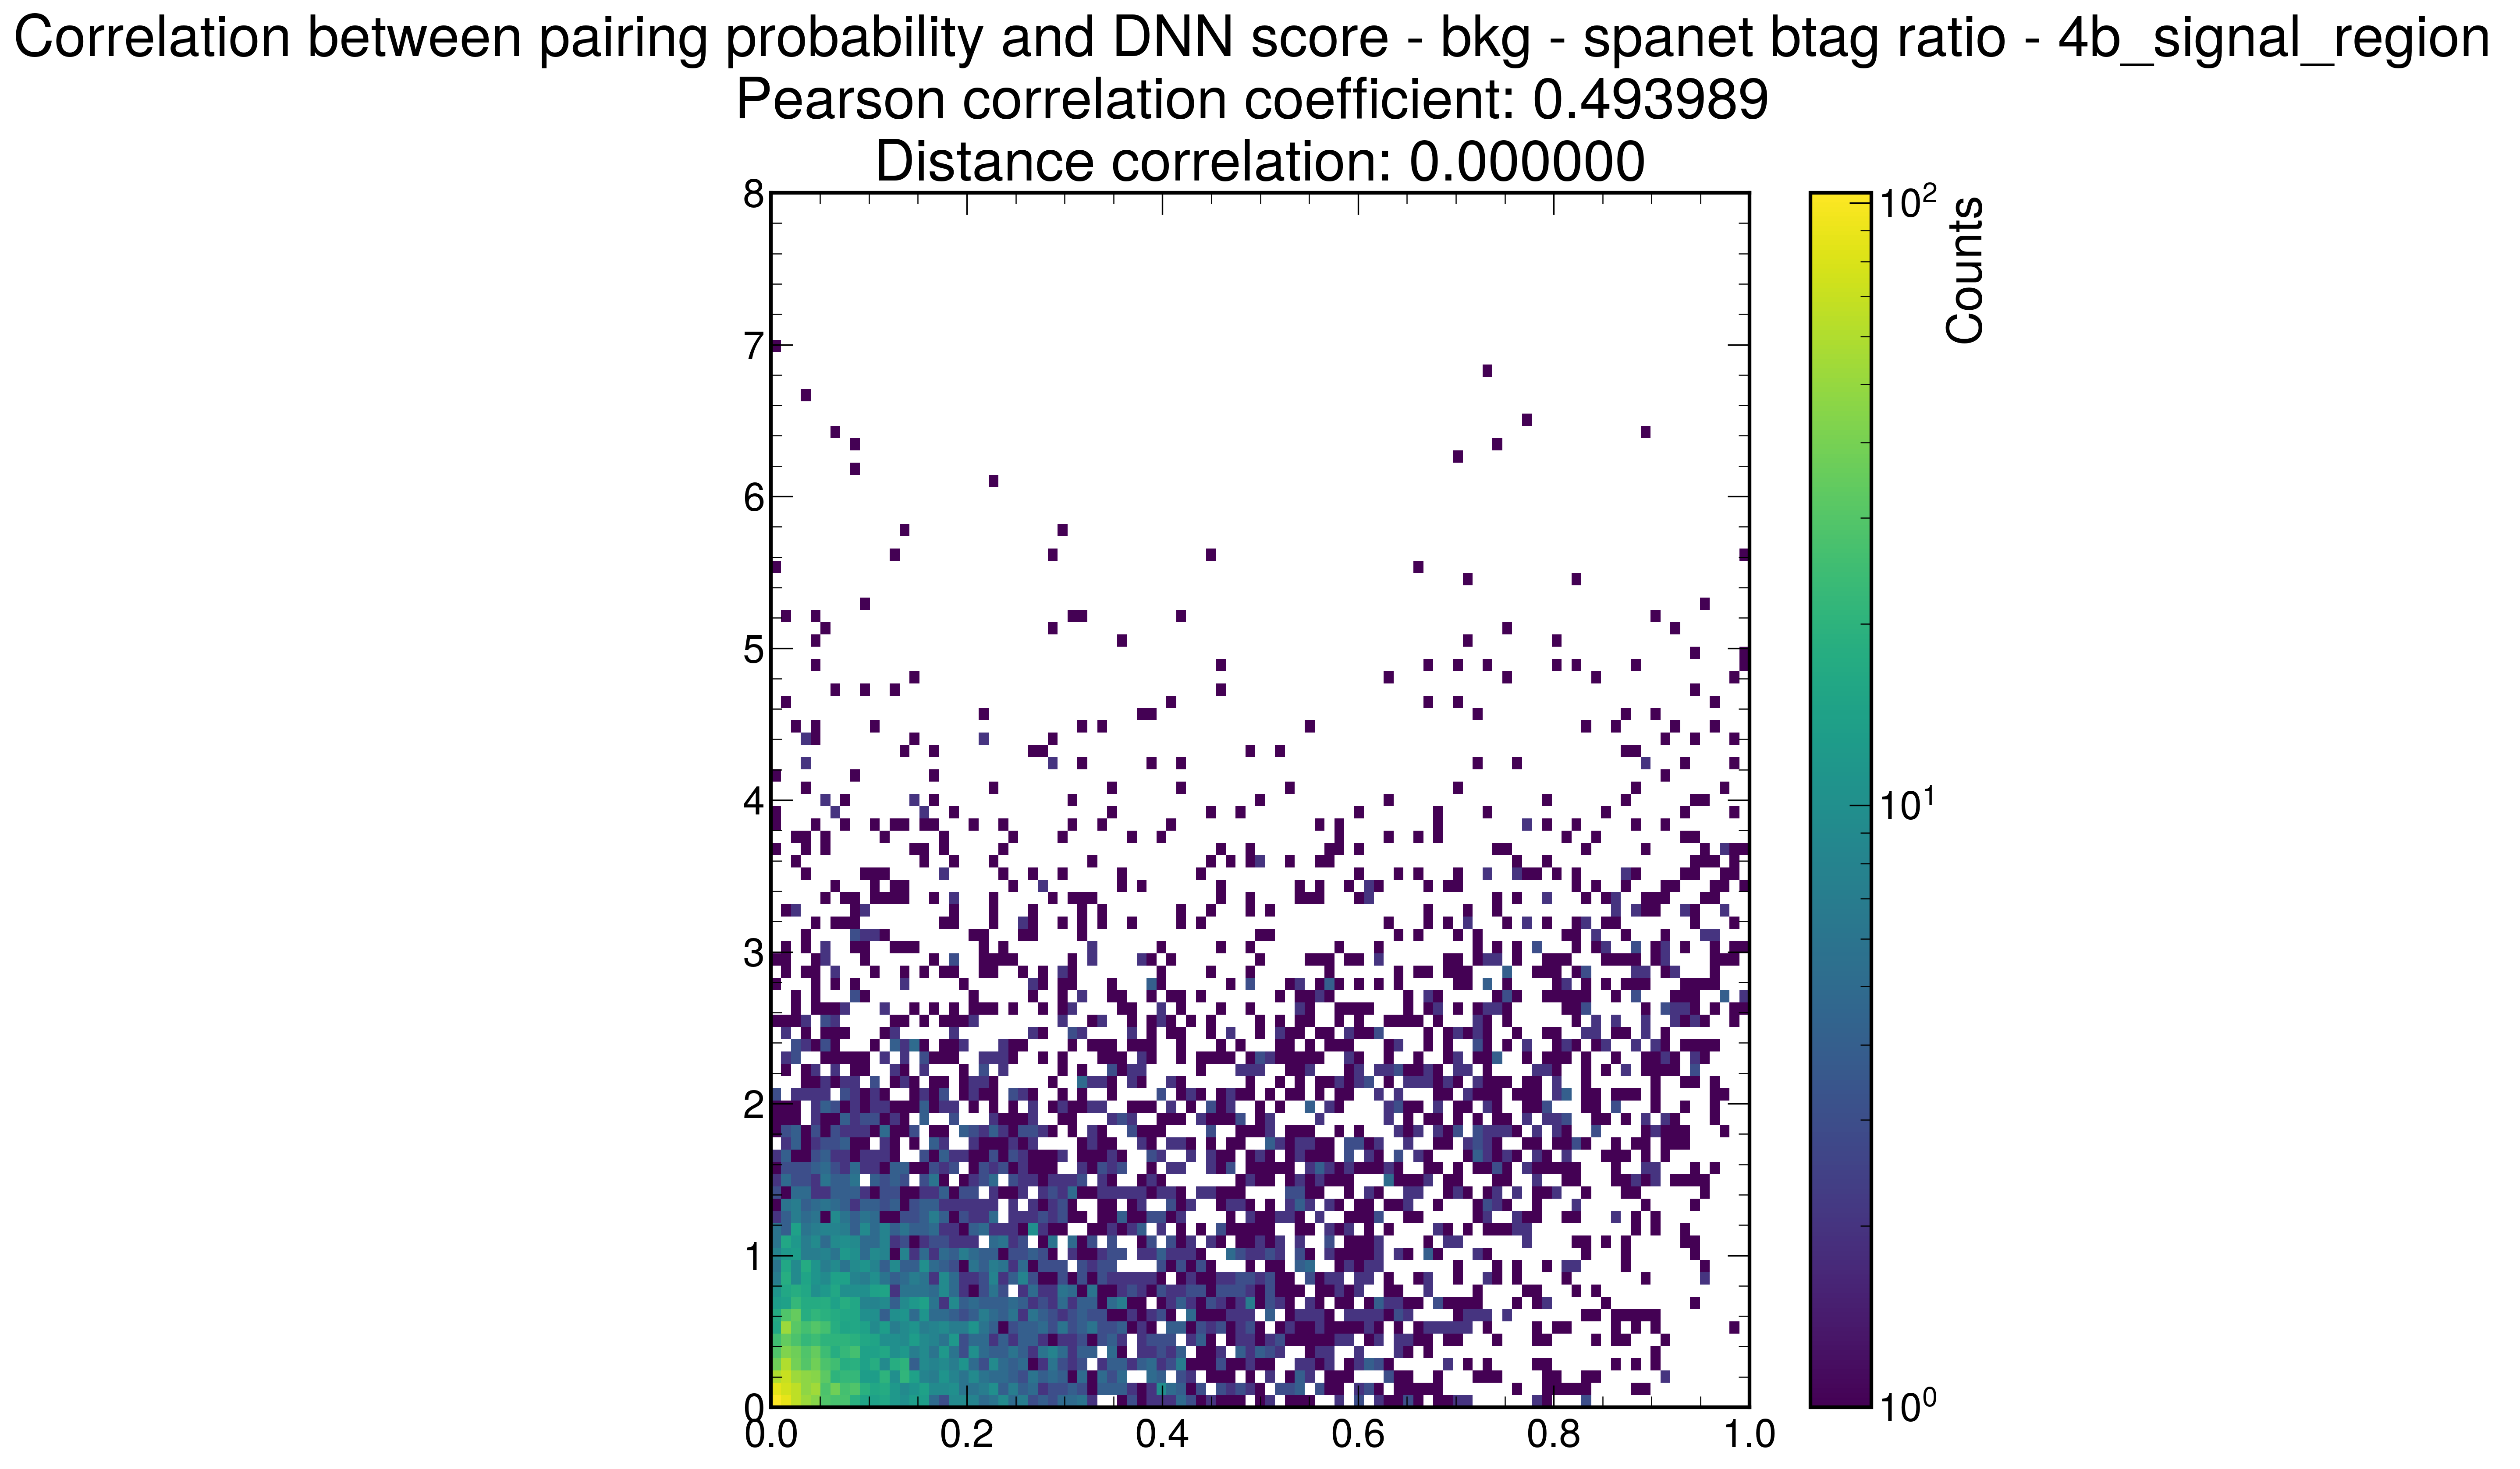

Pearson correlation coefficient (spanet ): 0.493328


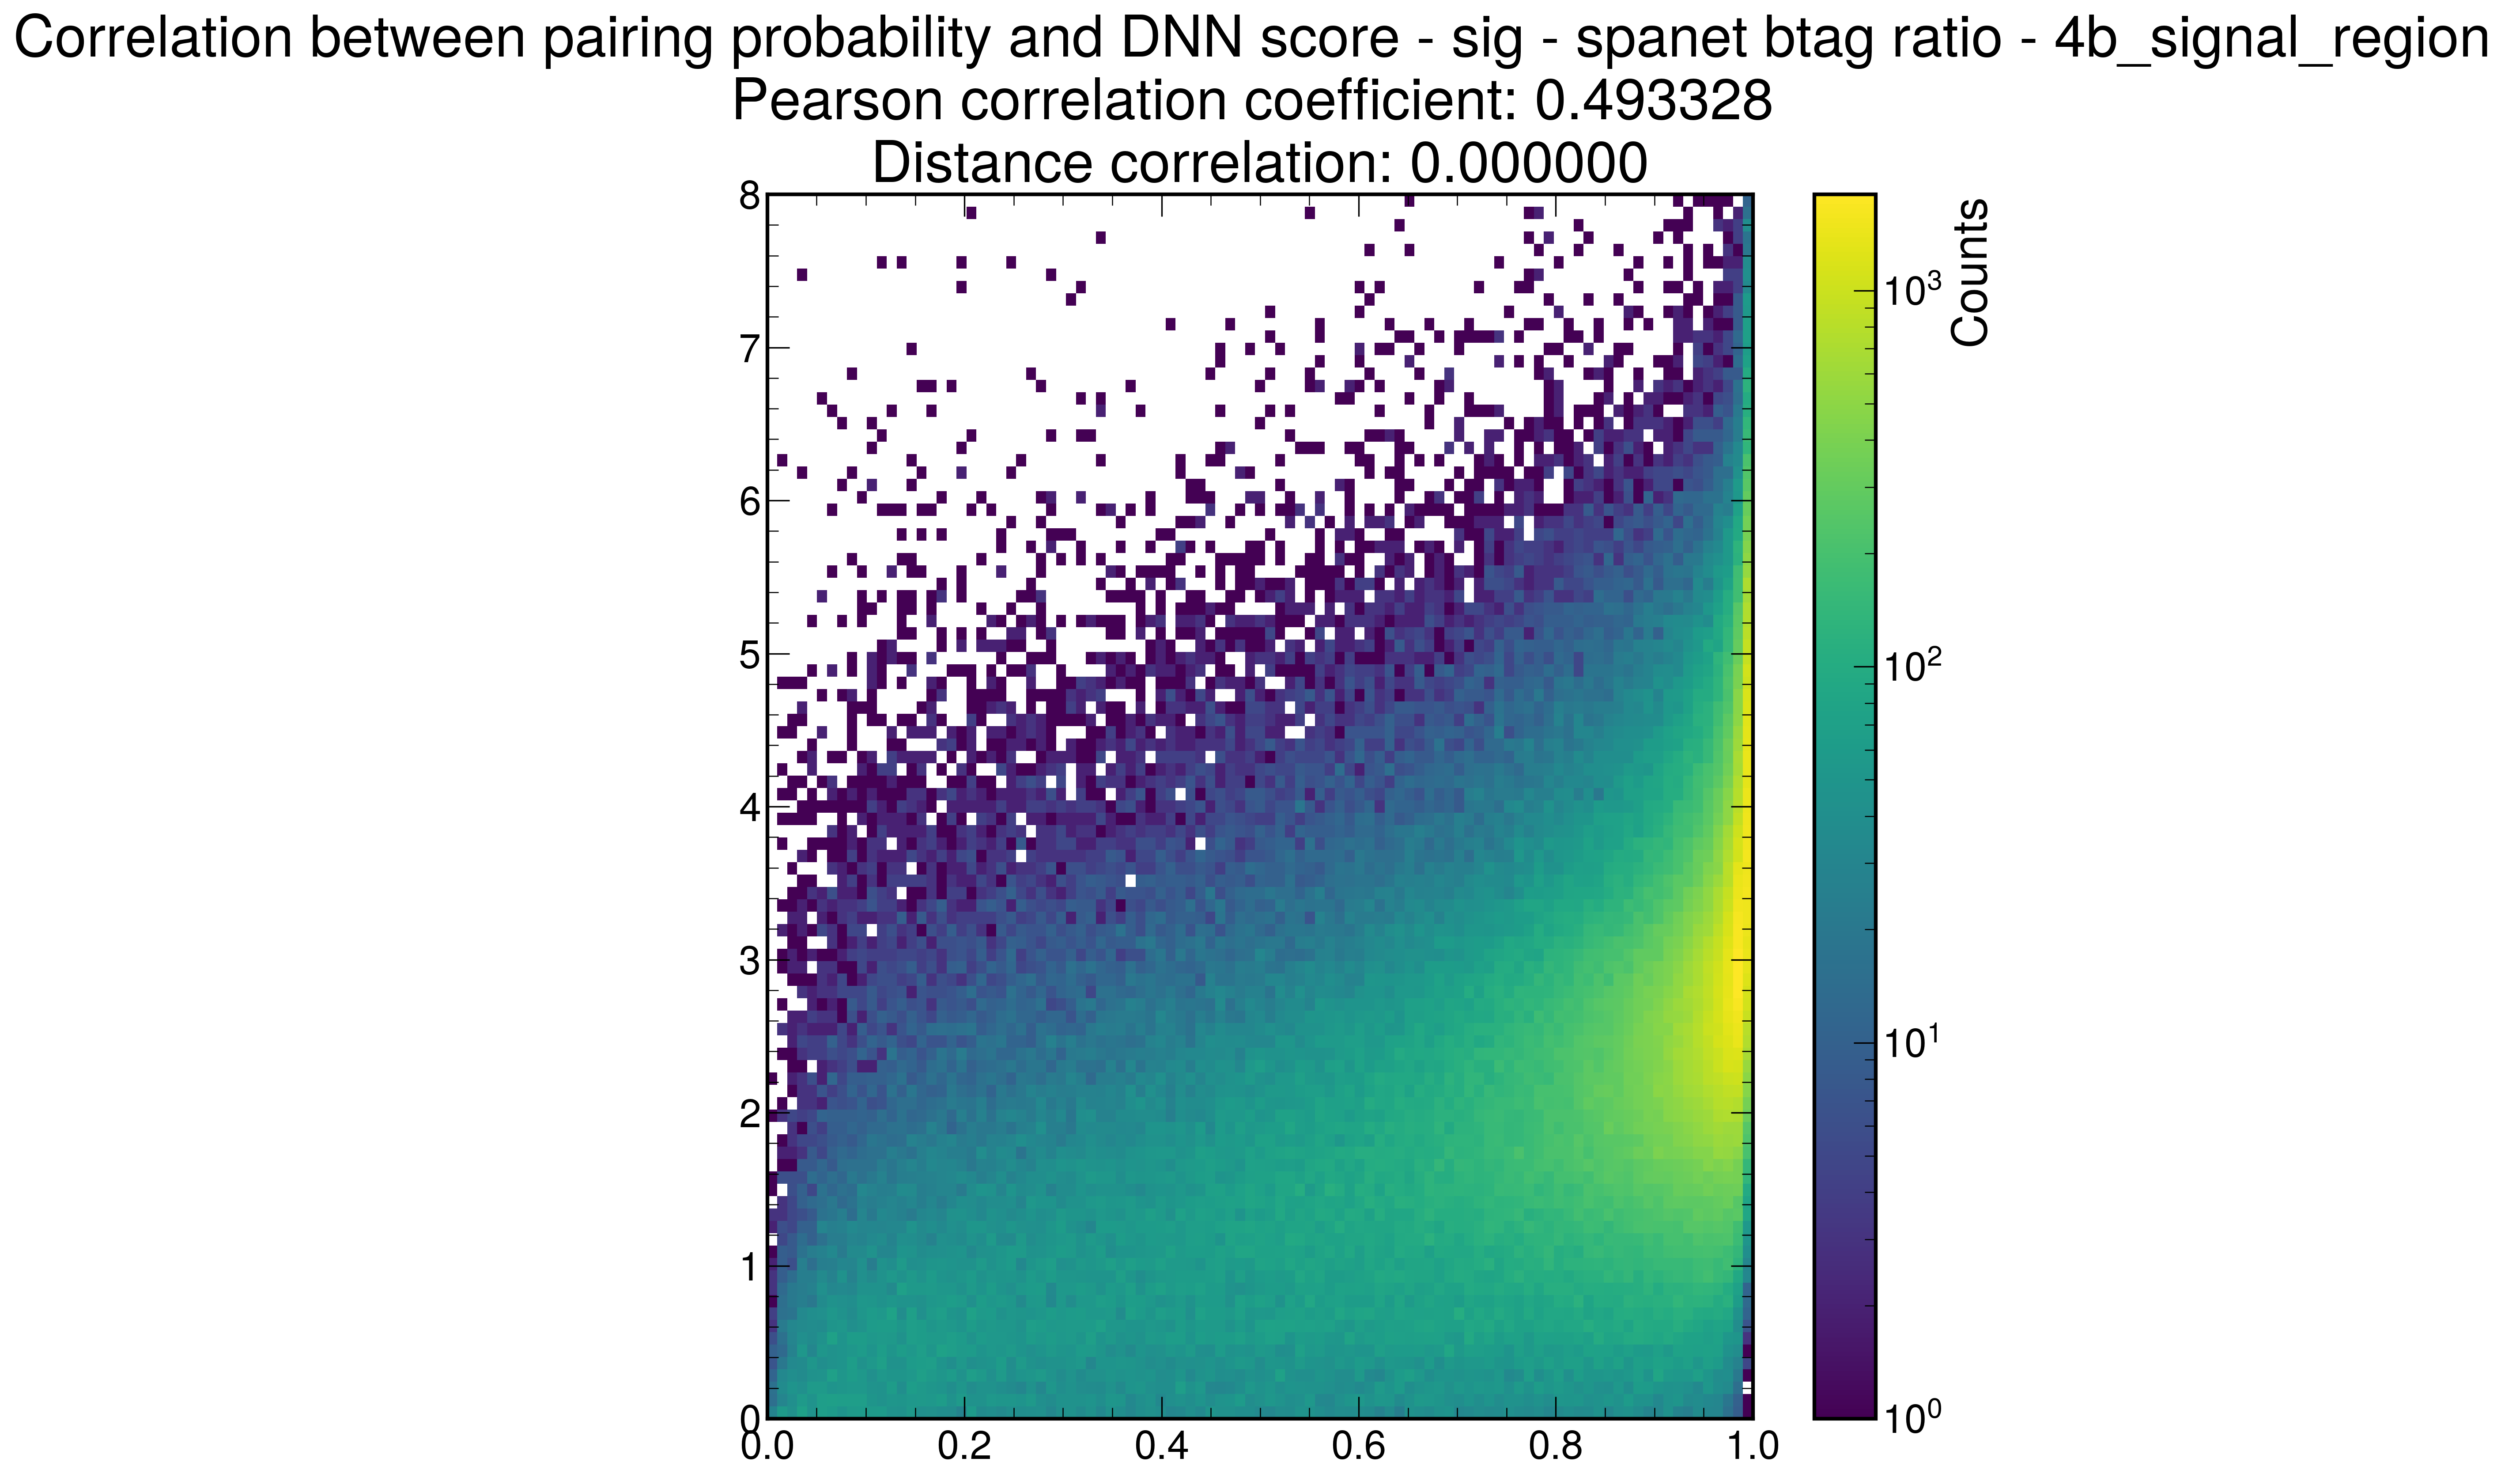

In [16]:
correlation_plot(col_bkg_dnn_bratio["events_sig_bkg_dnn_score"][:NUM_EVENTS], col_bkg_dnn_bratio["events_Arctanh_Delta_pairing_probabilities"][:NUM_EVENTS], "Correlation between pairing probability and DNN score - bkg - spanet btag ratio - 4b_signal_region")
correlation_plot(col_sig_dnn_bratio["events_sig_bkg_dnn_score"][:NUM_EVENTS], col_sig_dnn_bratio["events_Arctanh_Delta_pairing_probabilities"][:NUM_EVENTS], "Correlation between pairing probability and DNN score - sig - spanet btag ratio - 4b_signal_region")

# Compare sig and bkg different distributions


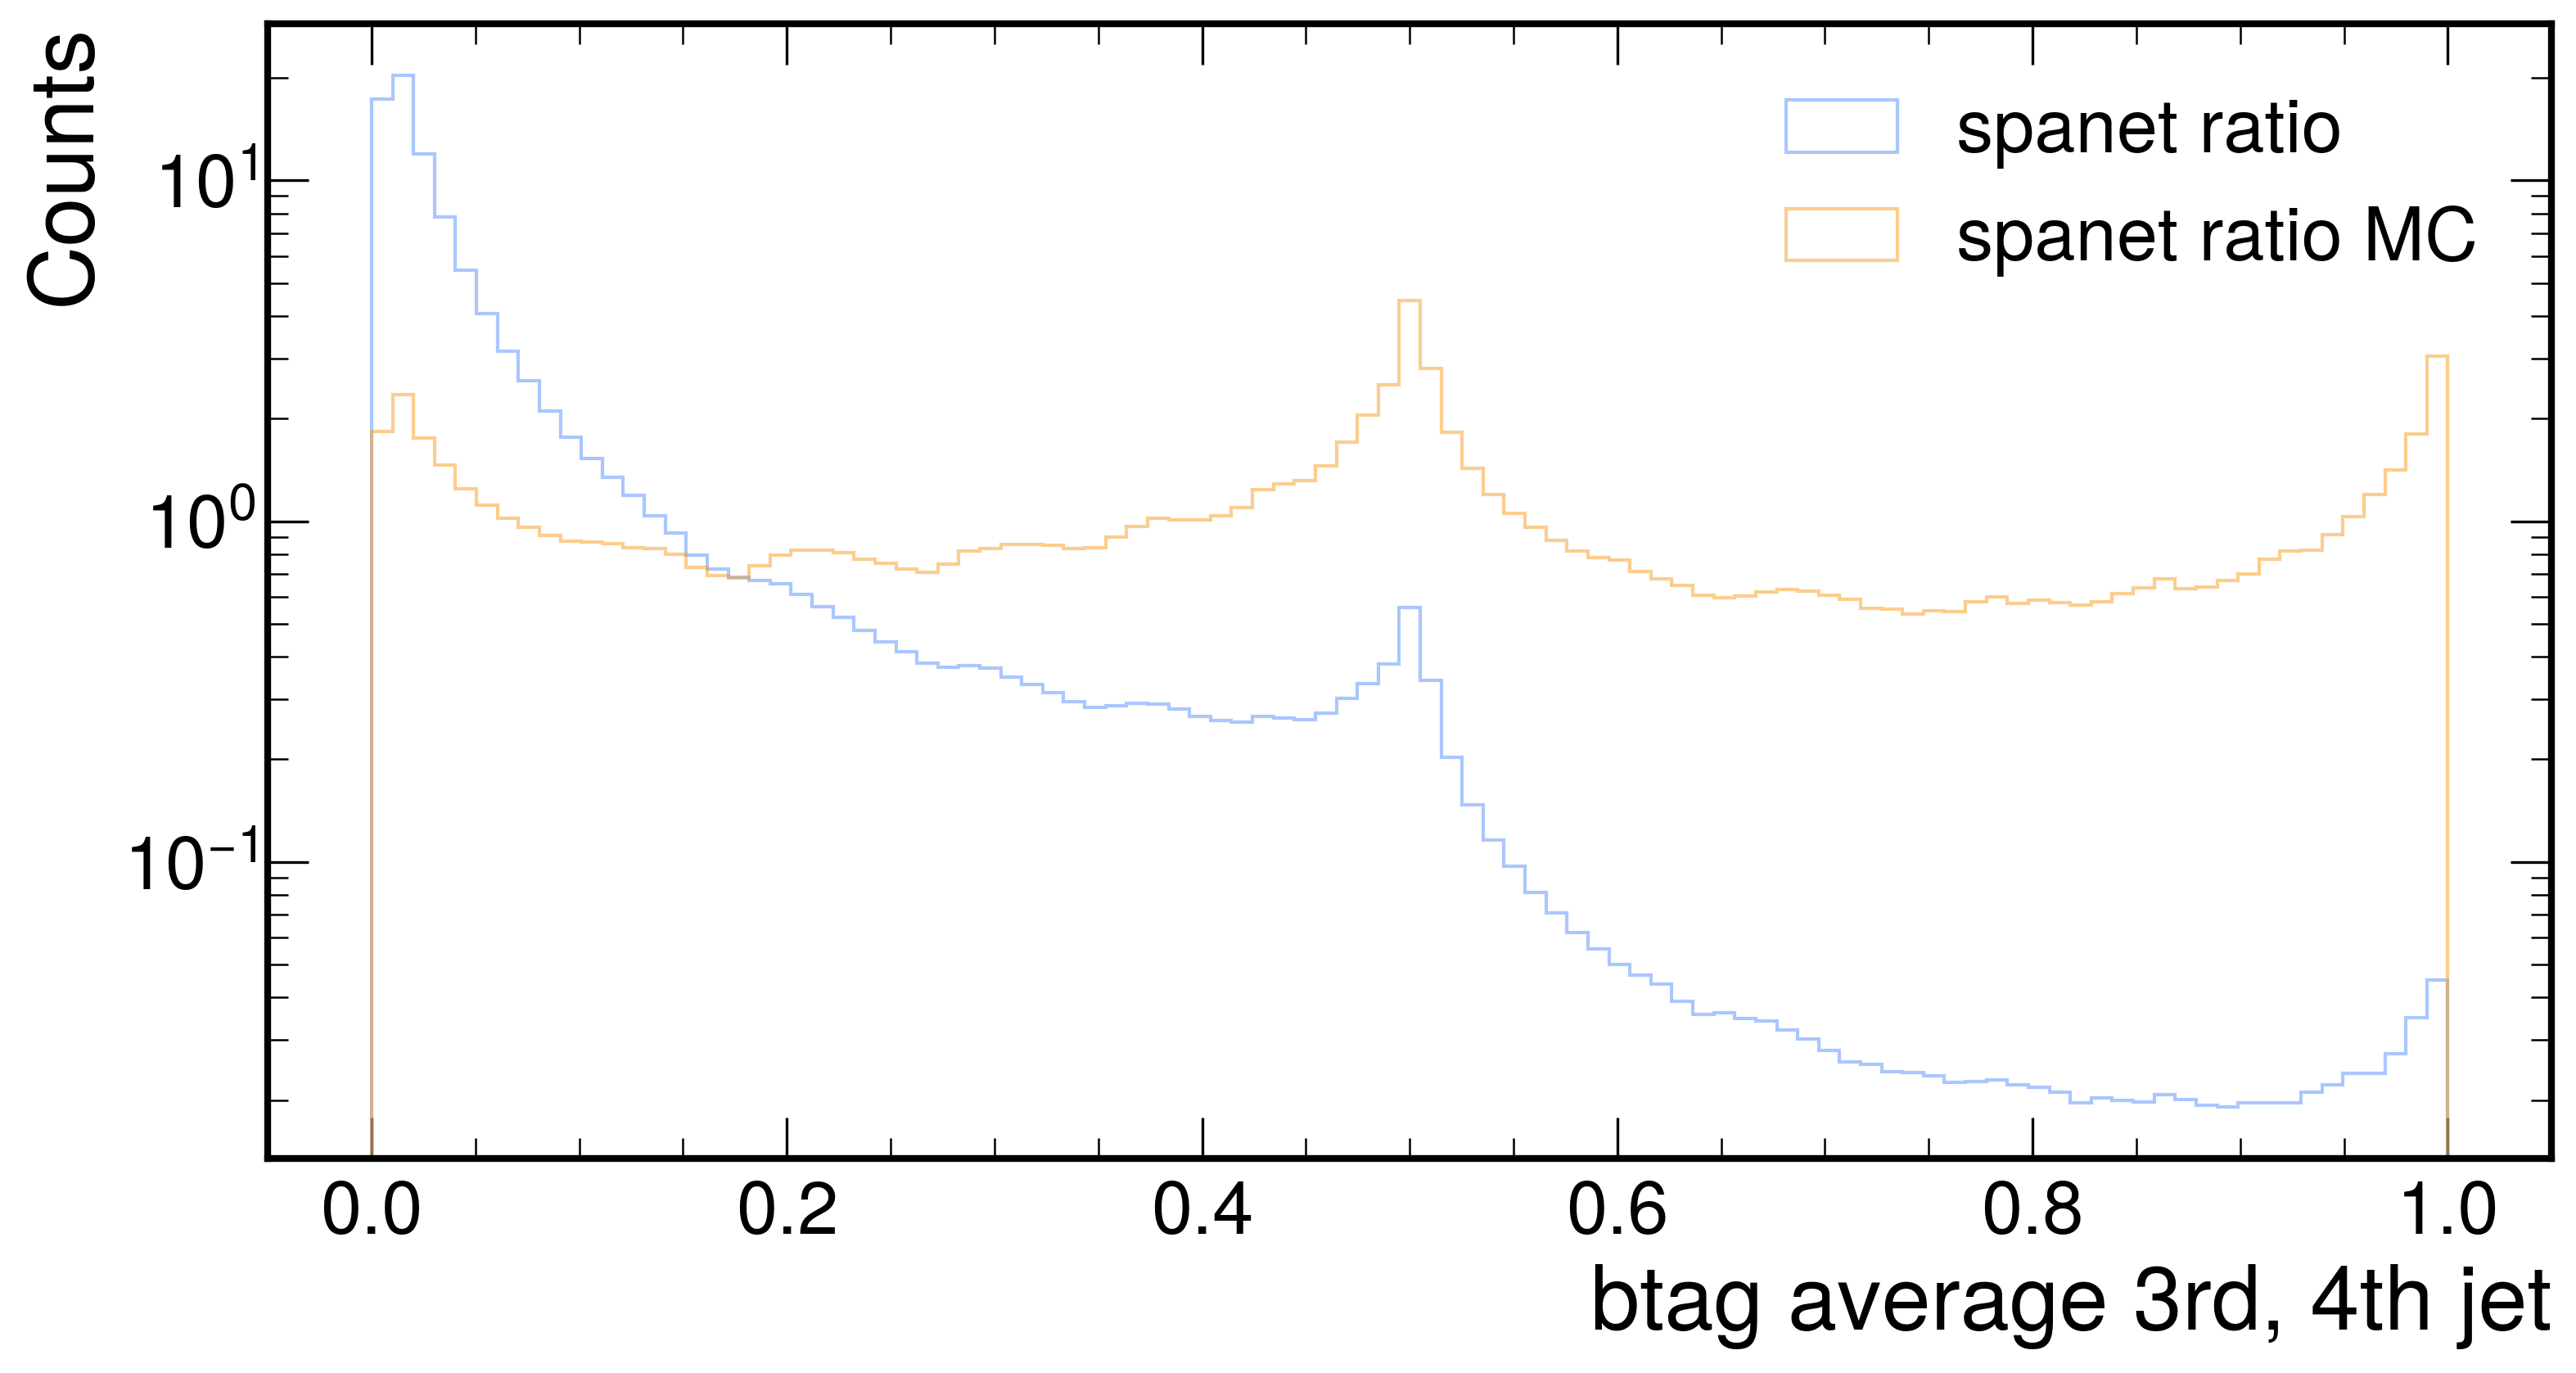

In [ ]:
# plot the btag 3+4 jet of signal and bkg
plt.figure(figsize=(12, 6))
plt.hist(
    (btag_spanet_ratio_unflattened[:, 2]+btag_spanet_ratio_unflattened[:, 3])/2,
    bins=np.linspace(0, 1, 100),
    label="spanet ratio",
    alpha=0.5,
    histtype="step",
    density=True
)
plt.hist(
    (btag_spanet_ratio_mc_unflattened[:, 2]+btag_spanet_ratio_mc_unflattened[:, 3])/2,
    bins=np.linspace(0, 1, 100),
    label="spanet ratio MC",
    alpha=0.5,
    histtype="step",
    density=True
)
plt.legend()
plt.xlabel("btag average 3rd, 4th jet")
plt.ylabel("Counts")
plt.yscale("log")
plt.show()


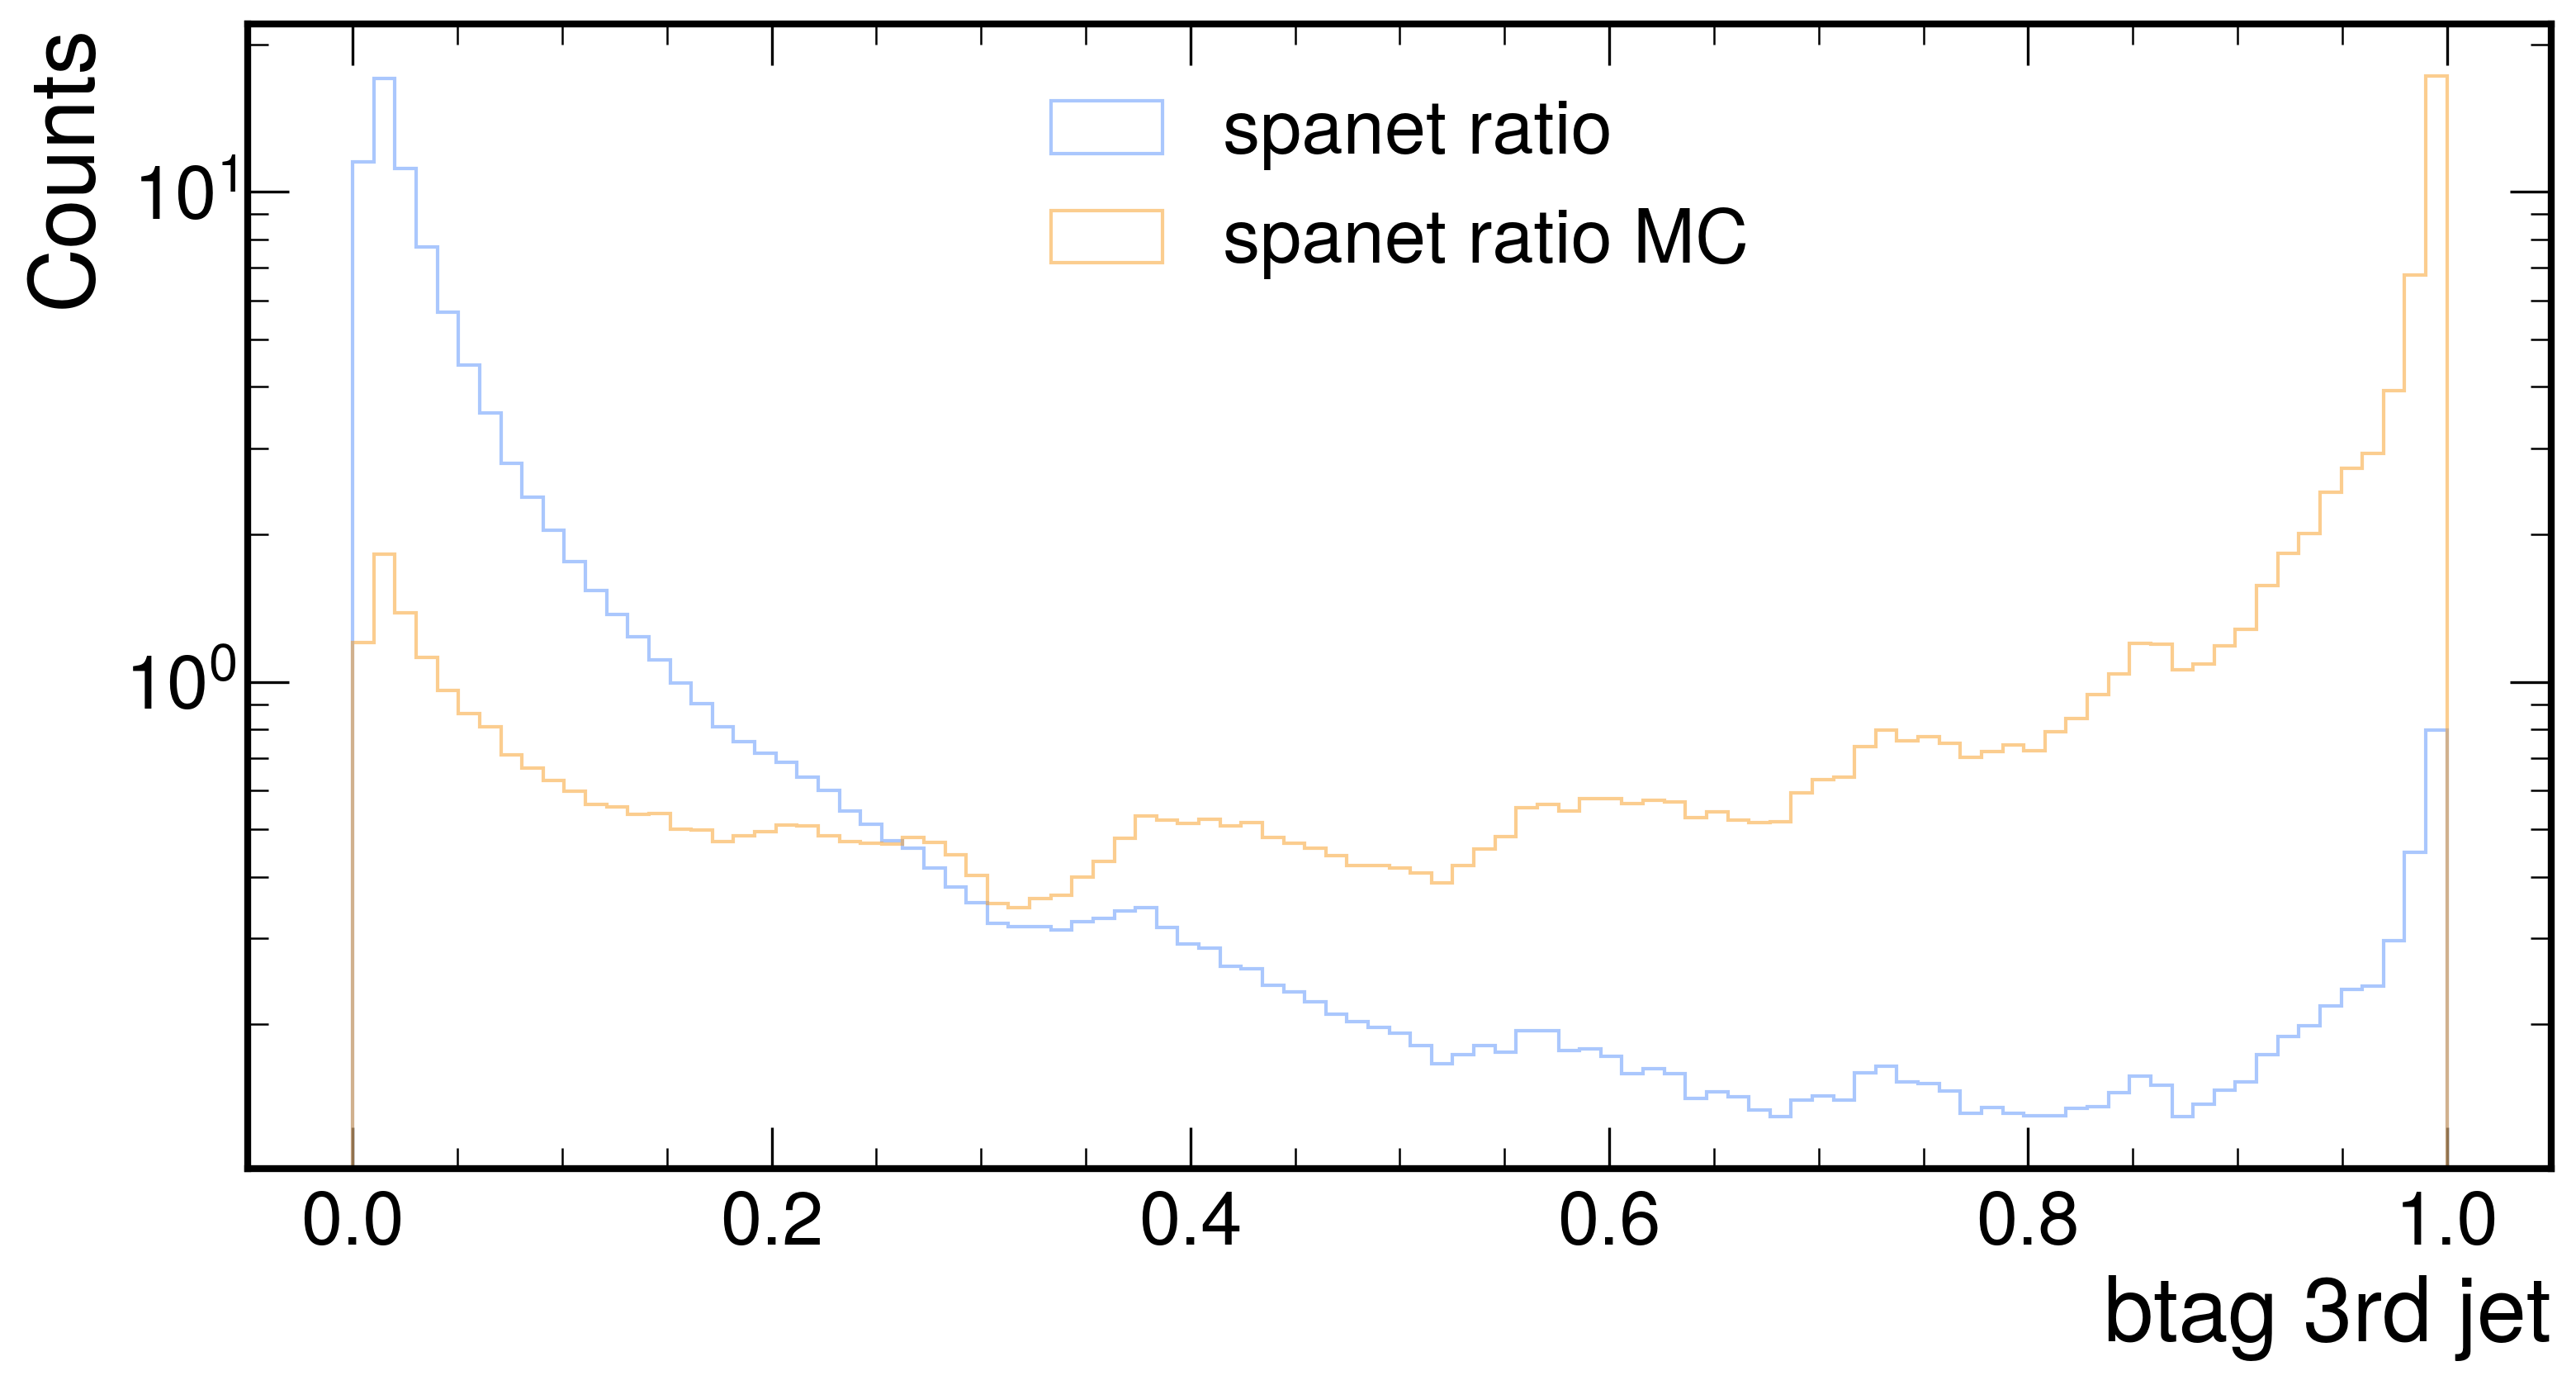

In [ ]:
# plot the btag 3 jet of signal and bkg
plt.figure(figsize=(12, 6))
plt.hist(
    btag_spanet_ratio_unflattened[:, 2],
    bins=np.linspace(0, 1, 100),
    label="spanet ratio",
    alpha=0.5,
    histtype="step",
    density=True
)
plt.hist(
    btag_spanet_ratio_mc_unflattened[:, 2],
    bins=np.linspace(0, 1, 100),
    label="spanet ratio MC",
    alpha=0.5,
    histtype="step",
    density=True
)
plt.legend()
plt.xlabel("btag 3rd jet")
plt.ylabel("Counts")
plt.yscale("log")
plt.show()


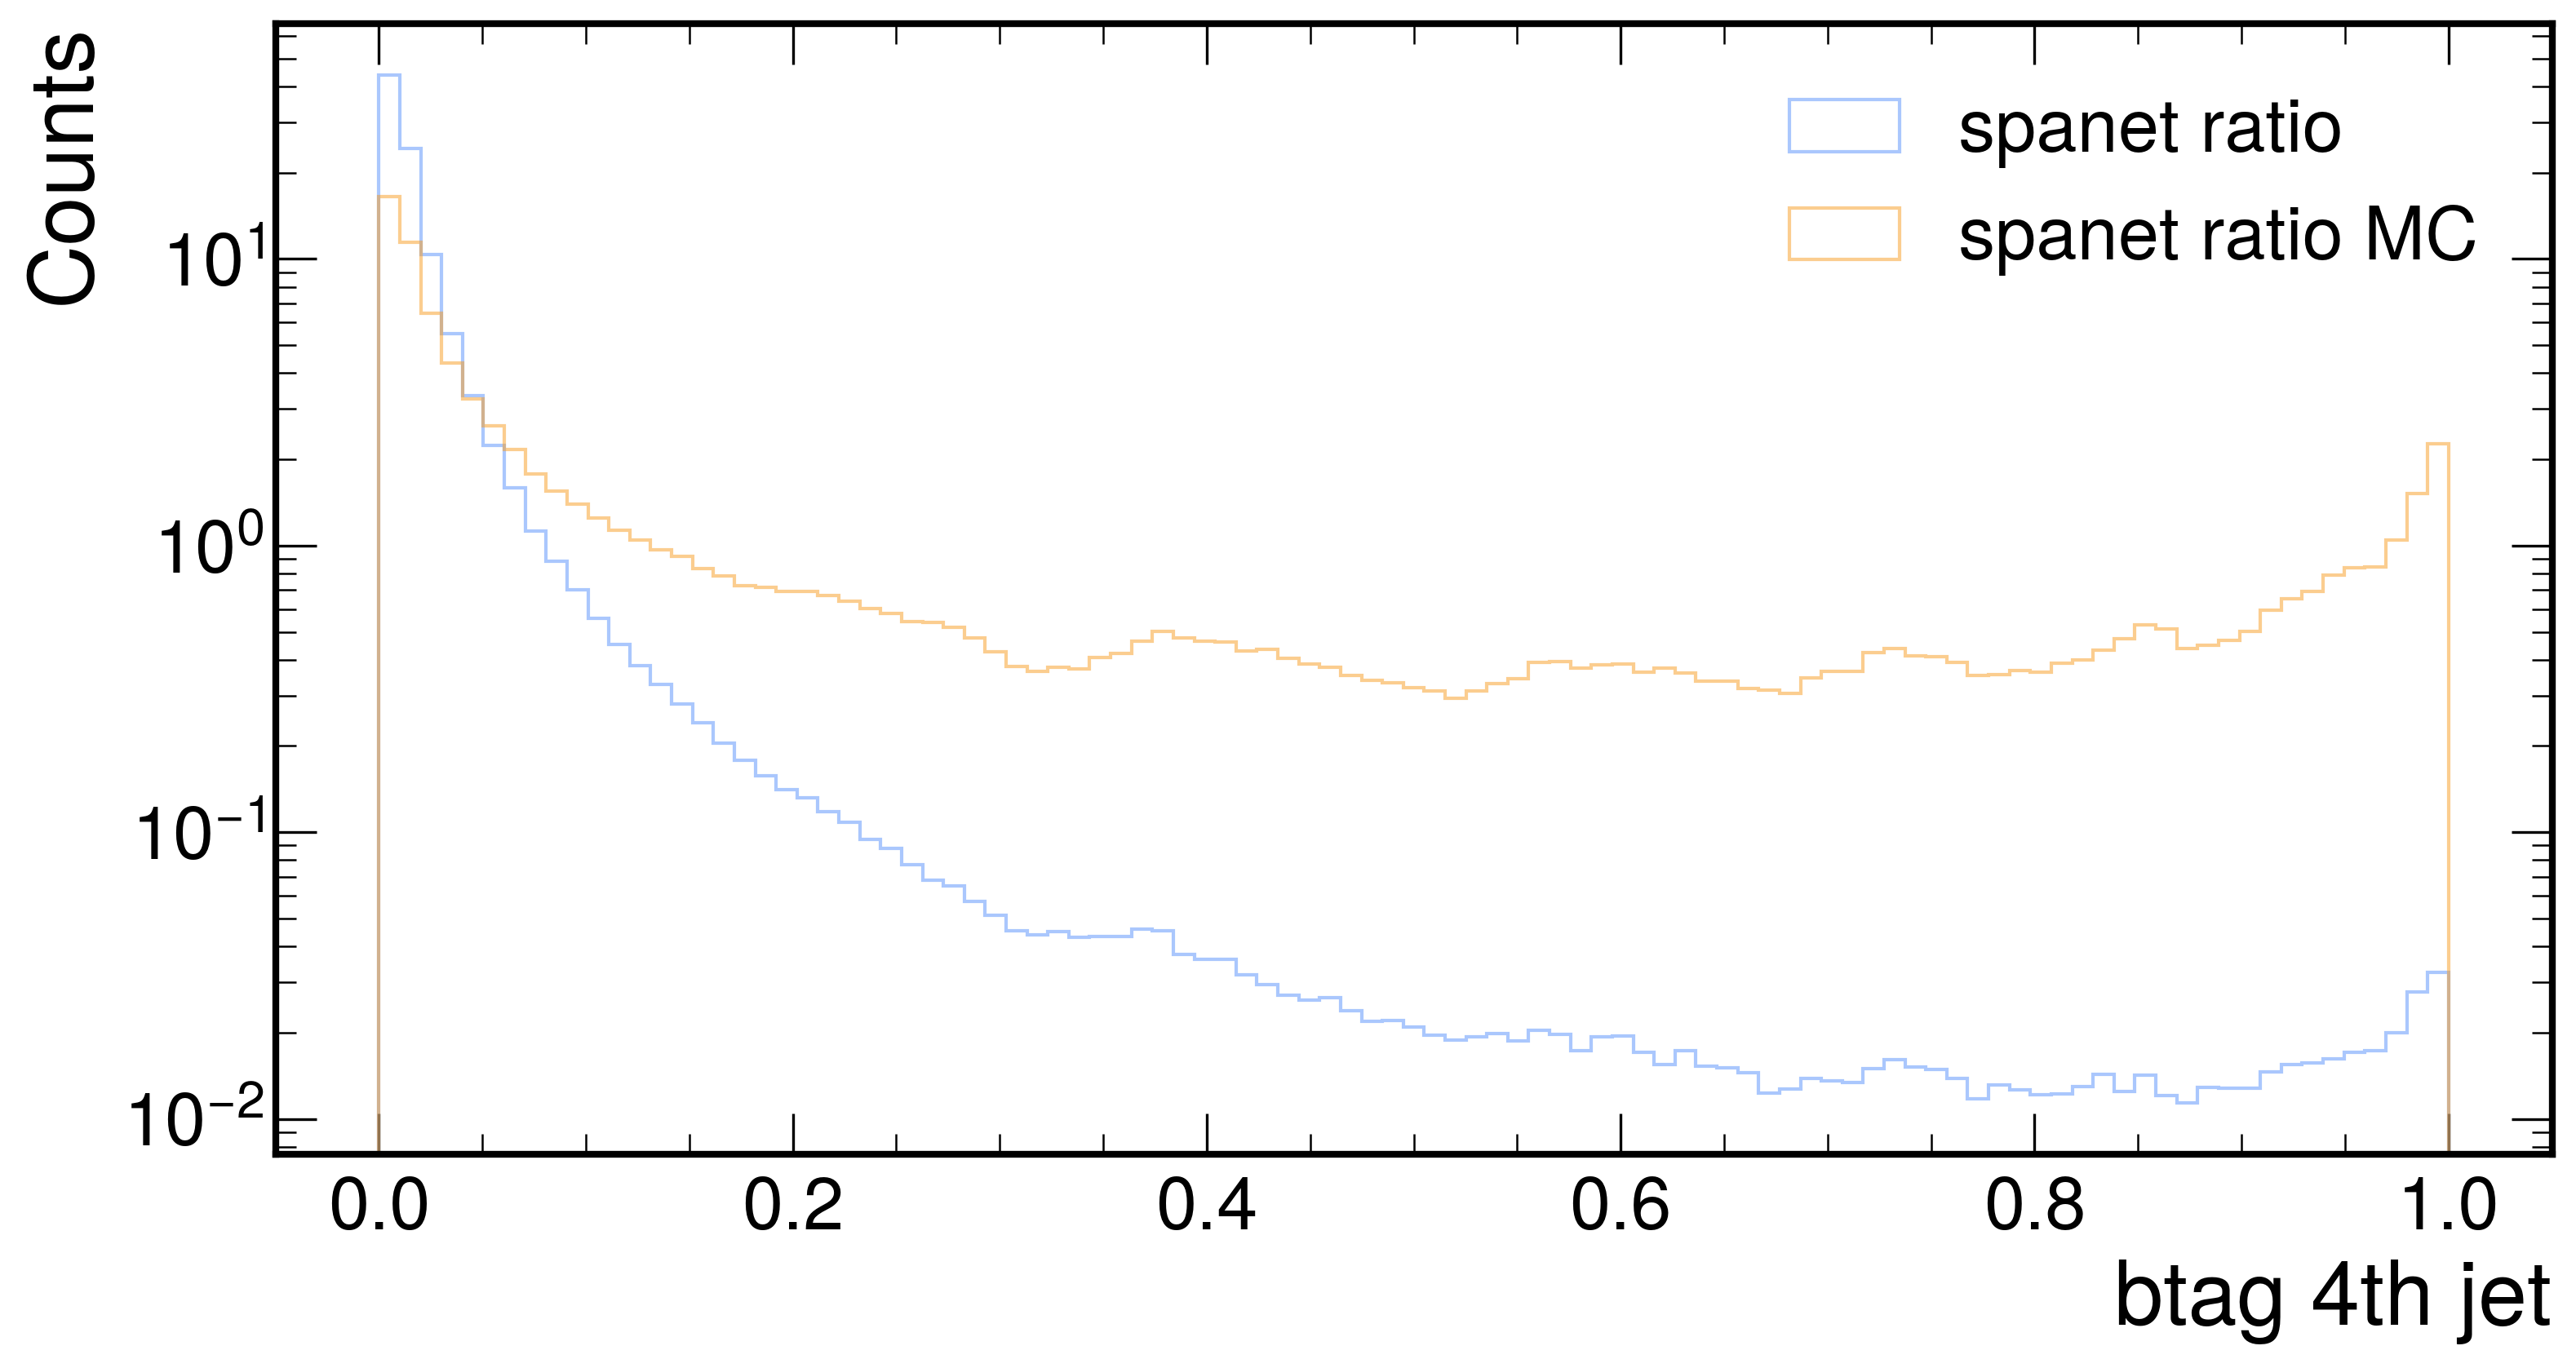

In [25]:
# plot the btag 4 jet of signal and bkg
plt.figure(figsize=(12, 6))
plt.hist(
    btag_spanet_ratio_unflattened[:, 3],
    bins=np.linspace(0, 1, 100),
    label="spanet ratio",
    alpha=0.5,
    histtype="step",
    density=True
)
plt.hist(
    btag_spanet_ratio_mc_unflattened[:, 3],
    bins=np.linspace(0, 1, 100),
    label="spanet ratio MC",
    alpha=0.5,
    histtype="step",
    density=True
)
plt.legend()
plt.xlabel("btag 4th jet")
plt.ylabel("Counts")
plt.yscale("log")
plt.show()


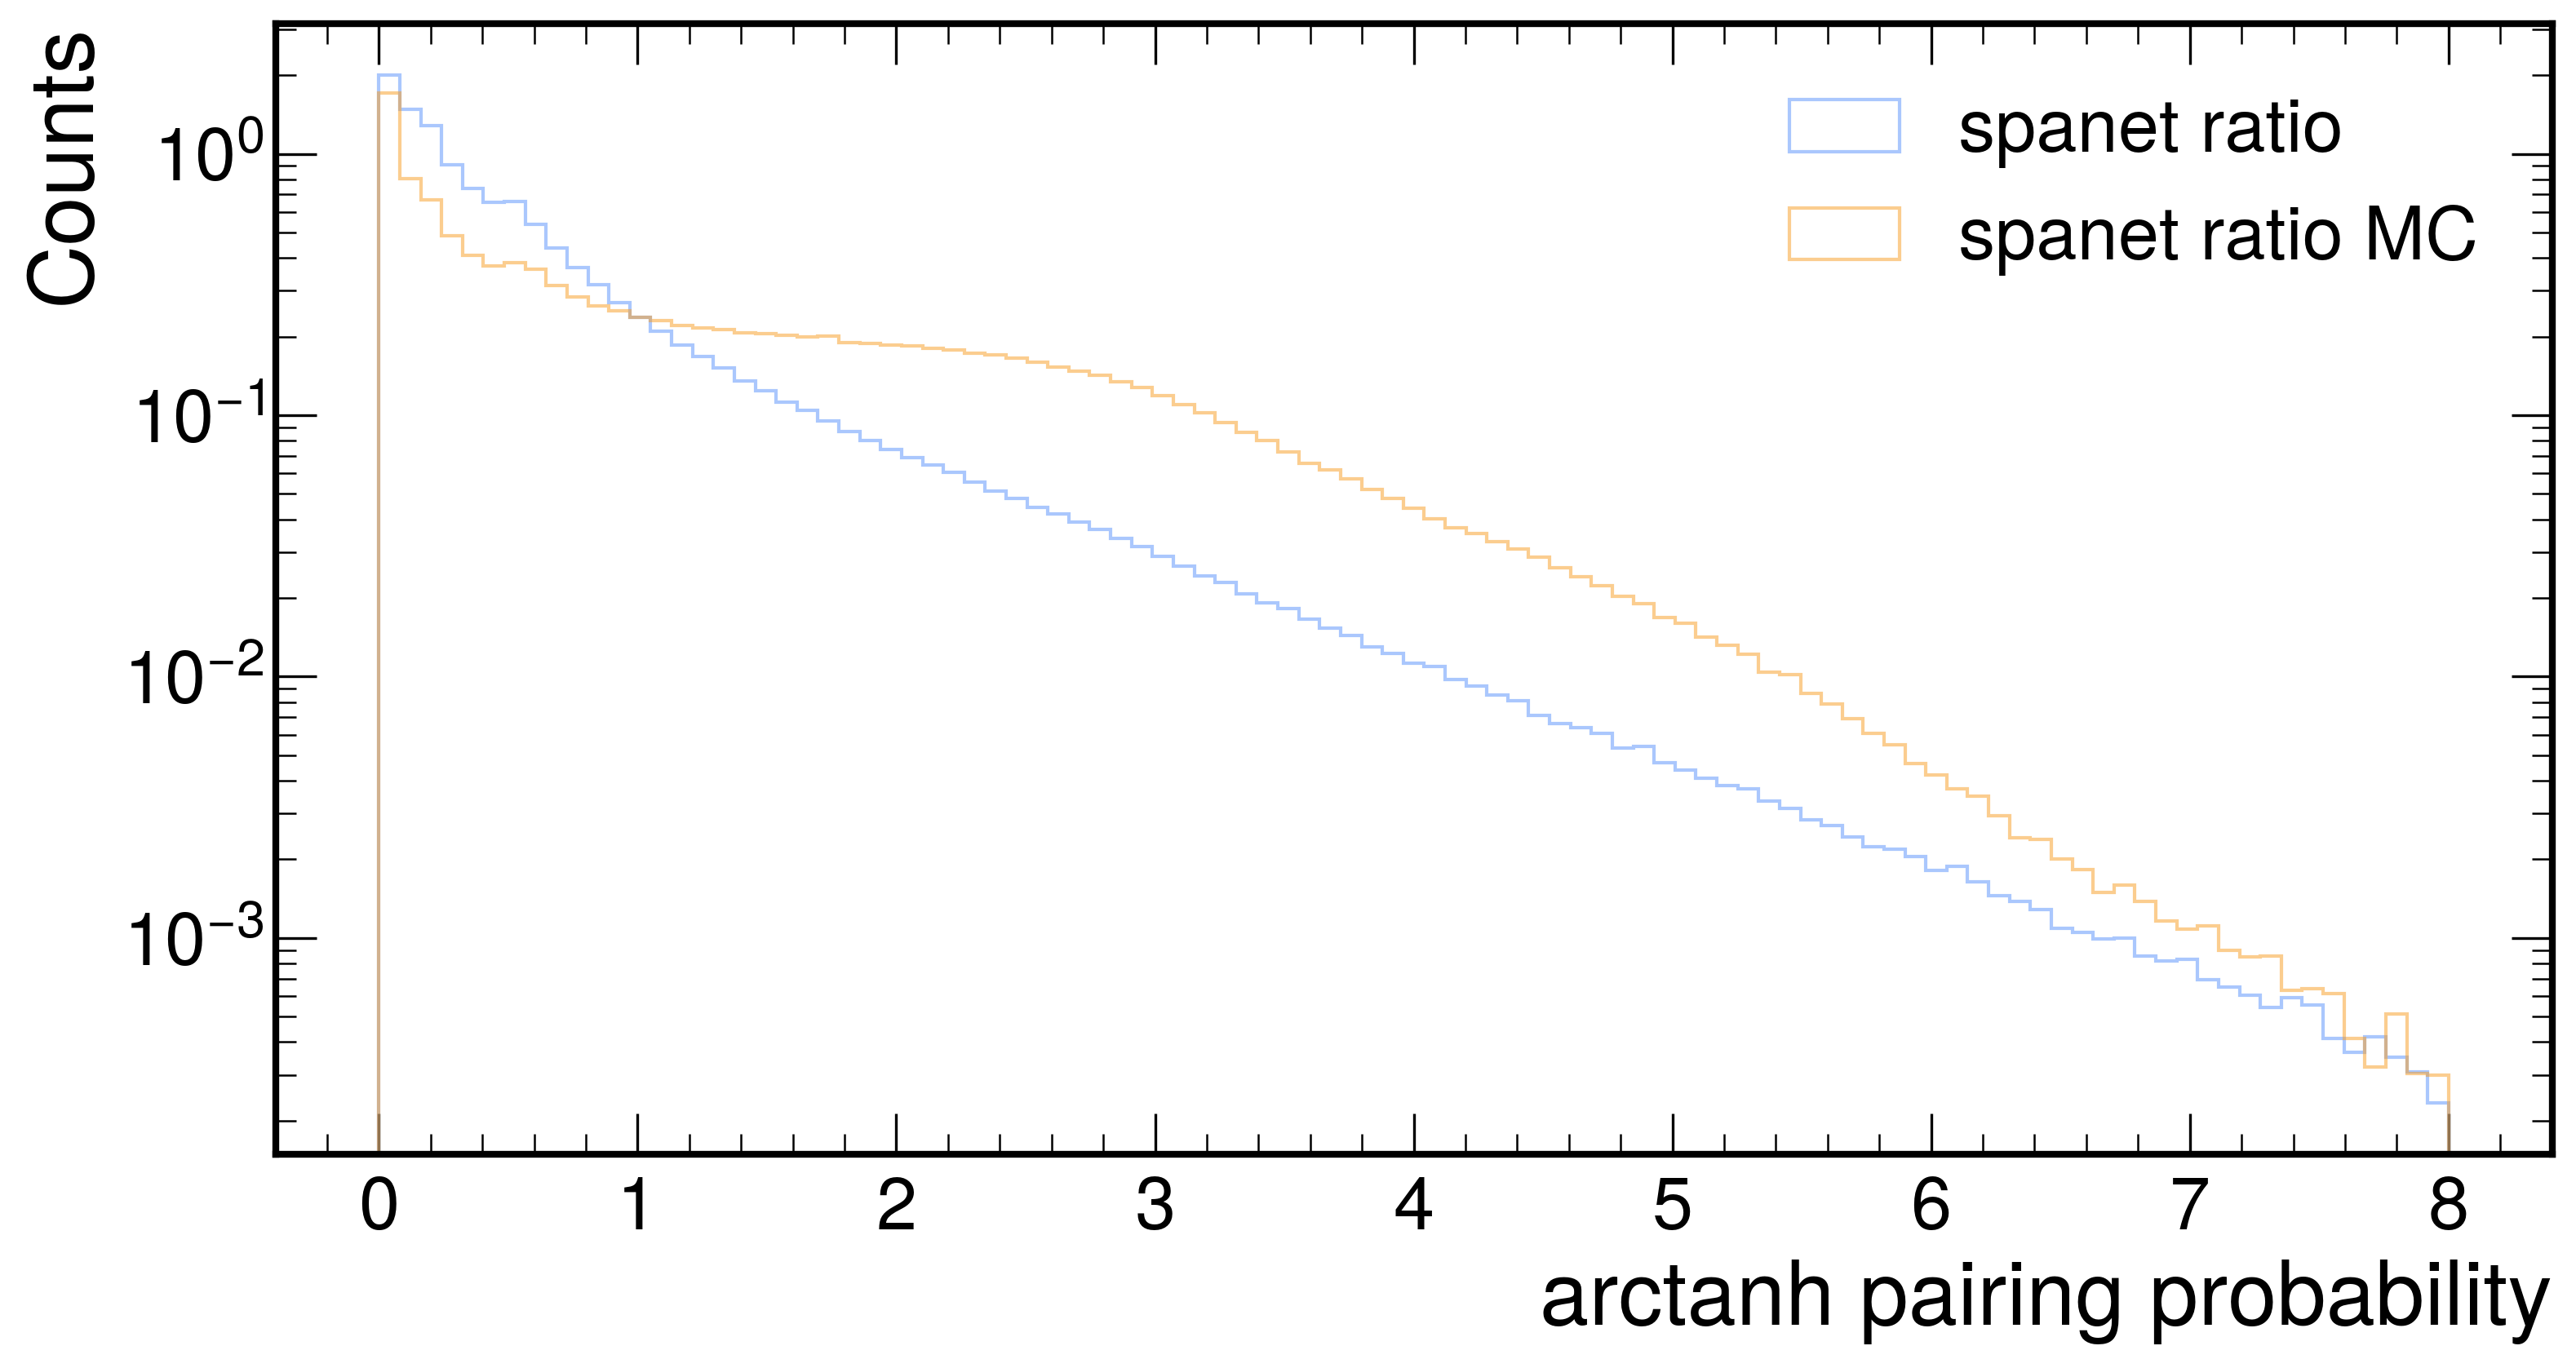

In [ ]:
# plot the arctanh pd of signal and bkg
plt.figure(figsize=(12, 6))
plt.hist(
    pd_spanet_ratio,
    bins=np.linspace(0, 8, 100),
    label="spanet ratio",
    alpha=0.5,
    histtype="step",
    density=True
)
plt.hist(
    pd_spanet_ratio_mc,
    bins=np.linspace(0, 8, 100),
    label="spanet ratio MC",
    alpha=0.5,
    histtype="step",
    density=True
)
plt.legend()
plt.xlabel("arctanh pairing probability")
plt.ylabel("Counts")
plt.yscale("log")
plt.show()


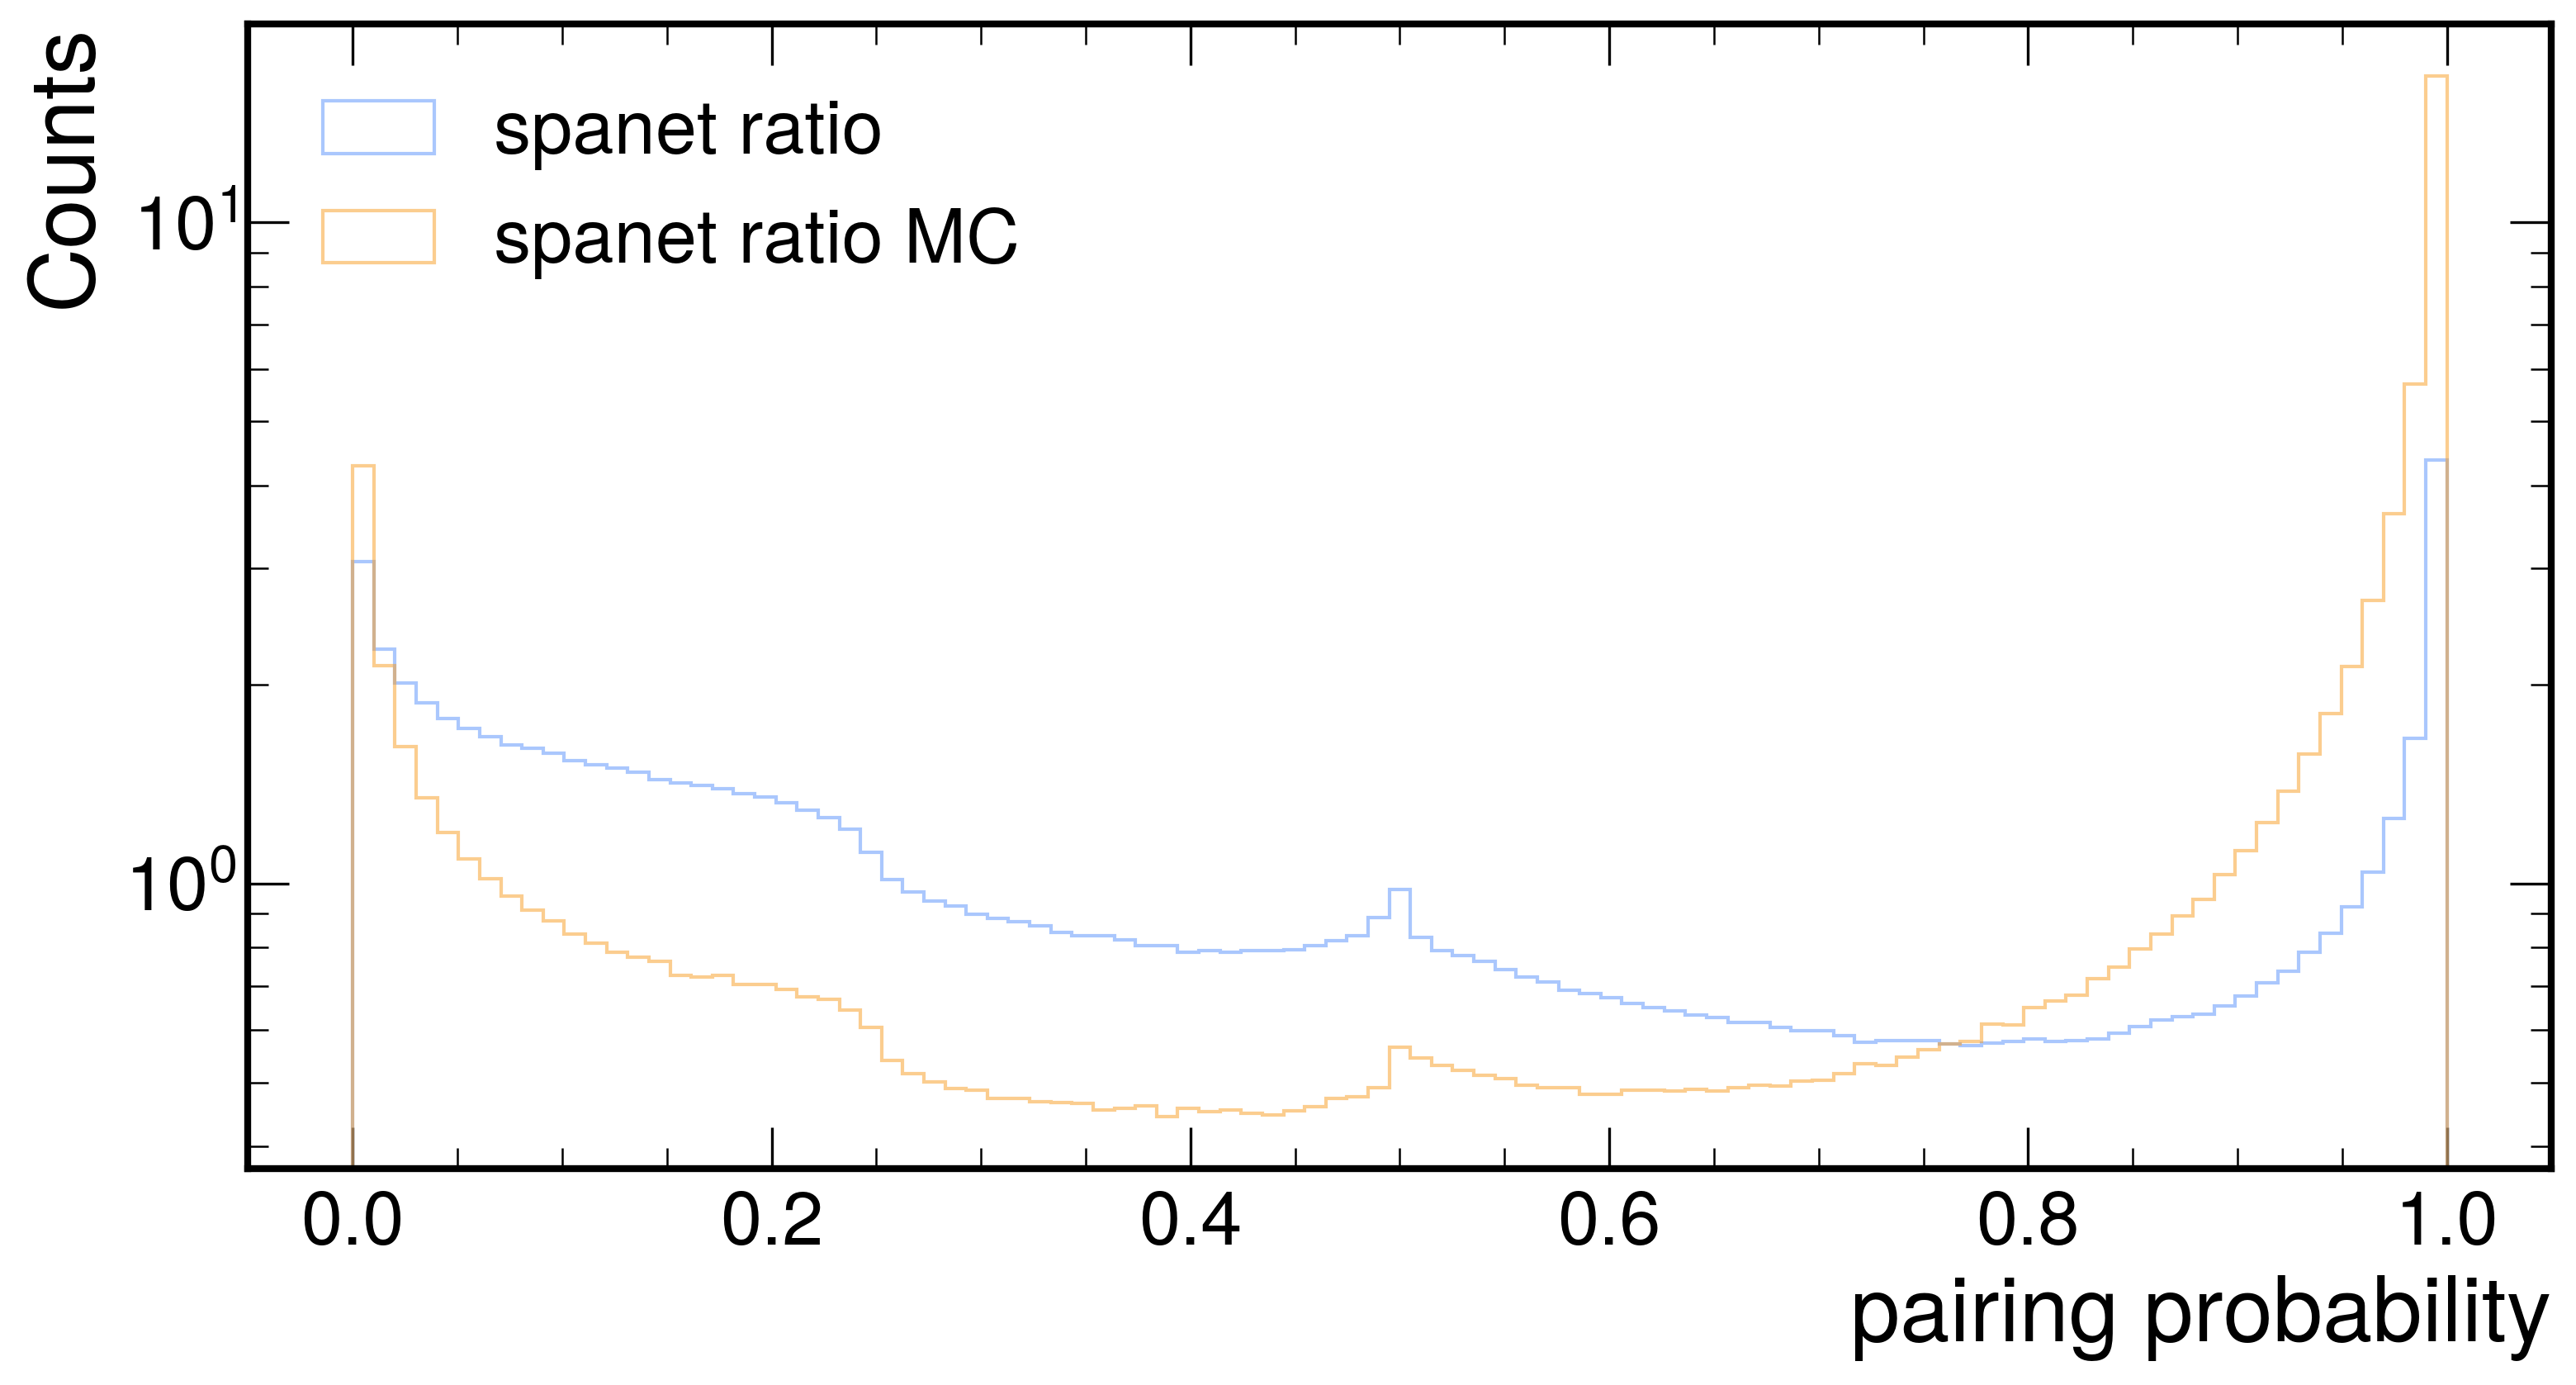

In [24]:
# plot the pd of signal and bkg
plt.figure(figsize=(12, 6))
plt.hist(
    np.tanh(pd_spanet_ratio),
    bins=np.linspace(0, 1, 100),
    label="spanet ratio",
    alpha=0.5,
    histtype="step",
    density=True
)
plt.hist(
    np.tanh(pd_spanet_ratio_mc),
    bins=np.linspace(0, 1, 100),
    label="spanet ratio MC",
    alpha=0.5,
    histtype="step",
    density=True
)
plt.legend()
plt.xlabel("pairing probability")
plt.ylabel("Counts")
plt.yscale("log")
plt.show()
